# Sample training script with naive competitive self-play.

# Switch directory in Google drive so as to import CDA env.


In [1]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

# %cd "/root/ray_results/"
# !ls -l
# #!rm -rf PPO_continuousDoubleAuction-v0_*
# !ls -l
# !pwd

# %cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
# !ls -l

# #!pip install -r requirements.txt

# #!pip install tensorflow==2.2.0
# #!pip install ray[rllib]==0.8.5

# #!pip show tensorflow
# #!pip show ray

# #!pip freeze > requirements.txt

# Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

from collections import defaultdict
from typing import Dict

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.policy import Policy
from ray.rllib.agents.ppo import ppo

from ray.rllib.agents.ppo.ppo import PPOTrainer
import ray.rllib.algorithms.ppo as ppo

from ray.rllib.env import BaseEnv
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.tune.logger import pretty_print

/home/ray/anaconda3/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/ray/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/ray/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/home/ray/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/home/ray/anaconda3/lib/python3

In [3]:
import sys
if "../" not in sys.path:
    sys.path.append("../")
    
print(sys.path)

['/home/ray/anaconda3/lib/python3.7/site-packages/ray/thirdparty_files', '/home/ray/anaconda3/lib/python3.7/site-packages/ray/pickle5_files', '/home/ray/gym-continuousDoubleAuction/gym_continuousDoubleAuction', '/home/ray/anaconda3/lib/python37.zip', '/home/ray/anaconda3/lib/python3.7', '/home/ray/anaconda3/lib/python3.7/lib-dynload', '', '/home/ray/anaconda3/lib/python3.7/site-packages', '/home/ray/gym-continuousDoubleAuction', '/home/ray/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/ray/.ipython', '../']


In [4]:
!pwd

/home/ray/gym-continuousDoubleAuction/gym_continuousDoubleAuction


In [5]:
from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies, create_train_policy_list
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import storage
from gym_continuousDoubleAuction.train.callbk.callbk_handler import store_eps_hist_data
from gym_continuousDoubleAuction.train.logger.log_handler import create_dir, log_g_store, load_g_store
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_storage, plot_LOB_subplot, plot_sum_ord_imb, plot_mid_prices
from gym_continuousDoubleAuction.train.helper.helper import ord_imb, sum_ord_imb, mid_price

# tf = try_import_tf()

# Global


In [6]:
# CDA_env args
num_agents = 4
num_trained_agent = 2 # 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 512 #4096 # per episode, -1 in arg. (~7.2s/1000steps/iter)
is_render = False 

In [7]:
# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
#num_cpus = 0.25                                
num_gpus = 0.75 #0                       
num_cpus_per_worker = 0.25                                
num_gpus_per_worker = 0
num_workers = 2
num_envs_per_worker = 4
batch_mode = "complete_episodes" 
rollout_fragment_length = 128
train_batch_size = max_step
sgd_minibatch_size = 256
num_iters = 1

train_policy_list =  ['policy_0', 'policy_1']


In [8]:
# log_base_dir = "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/results/"
log_base_dir = "/home/ray/gym-continuousDoubleAuction/results/"
log_dir = log_base_dir + "ray_results/"

# Chkpt & restore
local_dir = log_base_dir + "chkpt/"
chkpt_freq = 10
chkpt = 320
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = False # True / False

# log & load 
log_g_store_dir = log_base_dir + "log_g_store/"
print(f'log_base_dir:{log_base_dir}')
print(f'log_g_store_dir:{log_g_store_dir}')
create_dir(log_base_dir)    
create_dir(log_g_store_dir)    

log_base_dir:/home/ray/gym-continuousDoubleAuction/results/
log_g_store_dir:/home/ray/gym-continuousDoubleAuction/results/log_g_store/
Folder creation failed or folder already exists: /home/ray/gym-continuousDoubleAuction/results/
Folder creation failed or folder already exists: /home/ray/gym-continuousDoubleAuction/results/log_g_store/


In [9]:
# from ray.tune.registry import register_env

# def env_creator(env_config):
#     return MyEnv(...)  # return an env instance

# register_env("my_env", env_creator)
# algo = ppo.PPO(env="my_env")

In [10]:
# class MultiEnv(gym.Env):
#     def __init__(self, env_config):
#         # pick actual env based on worker and env indexes
#         self.env = gym.make(
#             choose_env_for(env_config.worker_index, env_config.vector_index))
#         self.action_space = self.env.action_space
#         self.observation_space = self.env.observation_space
#     def reset(self):
#         return self.env.reset()
#     def step(self, action):
#         return self.env.step(action)

# register_env("multienv", lambda config: MultiEnv(config))

In [11]:
# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(
    num_of_traders, 
    init_cash, 
    tick_size, 
    tape_display_length, 
    max_step, 
    is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# def env_creator(env_config):
#     return continuousDoubleAuctionEnv(
#         num_of_traders, 
#         init_cash, 
#         tick_size, 
#         tape_display_length,
#         max_step-1, 
#         is_render)

# register CDA env with RLlib 
register_env(
    "continuousDoubleAuction-v0", 
    lambda _: continuousDoubleAuctionEnv(
        num_of_traders, 
        init_cash, 
        tick_size, 
        tape_display_length,
        max_step-1, 
        is_render))
# register_env(
#     "continuousDoubleAuction-v0", 
#     env_creator)
# register_env("multienv", lambda config: MultiEnv(config))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.shutdown()
assert not ray.is_initialized()
# ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 
ray.init()
assert ray.is_initialized()

# Global storage, a ray actor that run on it's own process & it needs to be declared after ray.init().
# g_store = storage.options(name="g_store", detached=True).remote(num_agents)
g_store = storage.options(name="g_store", lifetime="detached").remote(num_agents)

2022-11-06 01:01:35,969	INFO worker.py:1515 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2022-11-06 01:01:37,747	WARNING worker.py:1829 -- It looks like you're creating a detached actor in an anonymous namespace. In order to access this actor in the future, you will need to explicitly connect to this namespace with ray.init(namespace="b424f94a-3d25-46c5-b331-f33aa2bac4f5", ...)


# Policies

In [12]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

def policy_mapper(agent_id):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:            
            return "policy_{}".format(i)                

policies: {'policy_0': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_1': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_2': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_3': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {})}


# Call back.

In [13]:
class MyCallbacks(DefaultCallbacks):
    def on_episode_start(self, worker: RolloutWorker, base_env: BaseEnv,
                         policies: Dict[str, Policy],
                         episode: MultiAgentEpisode, **kwargs):
        """
        info["episode"] is a MultiAgentEpisode object.

        user_data dicts at 100000 items max, will auto replace old with new item at 1st index.
        hist_data dicts at 100 items max, will auto replace old with new item at 1st index.
        """
        #print("on_episode_start {}, _agent_to_policy {}".format(episode.episode_id, episode._agent_to_policy))

        prefix = "agt_"
        for i in range(num_agents):
            episode.user_data[prefix + str(i) + "_obs"] = []
            episode.user_data[prefix + str(i) + "_act"] = []
            episode.user_data[prefix + str(i) + "_reward"] = []
            episode.user_data[prefix + str(i) + "_NAV"] = []
            episode.user_data[prefix + str(i) + "_num_trades"] = []

            episode.hist_data[prefix + str(i) + "_reward"] = []
            episode.hist_data[prefix + str(i) + "_NAV"] = []
            episode.hist_data[prefix + str(i) + "_num_trades"] = []

    def on_episode_step(self, worker: RolloutWorker, base_env: BaseEnv,
                        episode: MultiAgentEpisode, **kwargs):
        """
        pole_angle = abs(episode.last_observation_for()[2])
        raw_angle = abs(episode.last_raw_obs_for()[2])
        assert pole_angle == raw_angle
        episode.user_data["pole_angles"].append(pole_angle)
        """

        prefix = "agt_"
        for i in range(num_agents):
            obs = episode.last_raw_obs_for(i)
            #obs = episode.last_observation_for(i)
            act = episode.last_action_for(i)
            reward = episode.last_info_for(i).get("reward")
            NAV = episode.last_info_for(i).get("NAV")
            NAV = None if NAV is None else float(NAV)
            num_trades = episode.last_info_for(i).get("num_trades")
        
            if reward is None:      # goto next agent.
                continue

            episode.user_data[prefix + str(i) + "_obs"].append(obs)    
            episode.user_data[prefix + str(i) + "_act"].append(act)    
            episode.user_data[prefix + str(i) + "_reward"].append(reward)    
            episode.user_data[prefix + str(i) + "_NAV"].append(NAV)    
            episode.user_data[prefix + str(i) + "_num_trades"].append(num_trades)          

    def on_episode_end(self, worker: RolloutWorker, base_env: BaseEnv,
                       policies: Dict[str, Policy], episode: MultiAgentEpisode,
                       **kwargs):
        #print("on_episode_end {}, episode.agent_rewards {}".format(episode.episode_id, episode.agent_rewards))
        """
        arg: {"env": .., "episode": ...}
        """

#         g_store = ray.util.get_actor("g_store")
        g_store = ray.get_actor("g_store")

        prefix = "agt_"
        for agt_id in range(num_agents):
            obs_key = prefix + str(agt_id) + "_obs"
            act_key = prefix + str(agt_id) + "_act"
            reward_key = prefix + str(agt_id) + "_reward"
            NAV_key = prefix + str(agt_id) + "_NAV"
            num_trades_key = prefix + str(agt_id) + "_num_trades"      

            # store into episode.hist_data
            store_eps_hist_data(episode, reward_key)
            store_eps_hist_data(episode, NAV_key)
            store_eps_hist_data(episode, num_trades_key)

            # store step data
            obs = episode.user_data[obs_key]
            act = episode.user_data[act_key]
            reward = episode.user_data[reward_key]
            NAV = episode.user_data[NAV_key]
            num_trades = episode.user_data[num_trades_key]
            ray.get(g_store.store_agt_step.remote(agt_id, obs, act, reward, NAV, num_trades))       
        
            # Store episode data.   
            eps_reward = np.sum(reward)
            eps_NAV = np.sum(NAV)
            eps_num_trades = np.sum(num_trades)
            ray.get(g_store.store_agt_eps.remote(agt_id, eps_reward, eps_NAV, eps_num_trades))

        ray.get(g_store.inc_eps_counter.remote())  

    def on_sample_end(self, worker: RolloutWorker, samples: SampleBatch,
                      **kwargs):
        """
        arg: {"samples": .., "worker": ...}

        Notes:
            https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py        
        """
        #print("on_sample_end returned sample batch of size {}".format(samples.count))

        """
        MultiAgentBatch_obj = info["samples"]
        MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
        MultiAgentBatch_count = MultiAgentBatch_obj.count

        access_sample_batches(MultiAgentBatch_policy_batches)
        print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
        print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object
        """

    def on_train_result(self, trainer, result: dict, **kwargs):
        """
        info["trainer"] is the trainer object.

        info["result"] contains a bunch of info such as episodic rewards for 
        each policy in info["result"][hist_stats] dictionary.
        """
        #print("trainer.train() result: {} -> {} episodes".format(trainer, result["episodes_this_iter"]))
        # you can mutate the result dict to add new fields to return
        result["callback_ok"] = True
        #print("on_train_result result", result)
    
        train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
        max_reward_ind = get_max_reward_ind(result, train_policies_name)
        max_reward_policy_name = train_policies_name[max_reward_ind]
        cp_weight(trainer, train_policies_name, max_reward_policy_name)    

#         g_store = ray.util.get_actor("g_store")   
        g_store = ray.get_actor("g_store")      

        prefix = "policy_policy_"
        suffix = "_reward"
        hist_stats = result["hist_stats"]
        eps_this_iter = result["episodes_this_iter"]
        for agt_id in range(num_agents):
            key = prefix + str(agt_id) + suffix
            for i in range(eps_this_iter):
                ray.get(g_store.store_agt_train.remote(agt_id, hist_stats[key][i]))

        #print("on_train_result info['result'] {}".format(info["result"]))     

    def on_postprocess_trajectory(
            self, worker: RolloutWorker, episode: MultiAgentEpisode,
            agent_id: str, policy_id: str, policies: Dict[str, Policy],
            postprocessed_batch: SampleBatch,
            original_batches: Dict[str, SampleBatch], **kwargs):
        #print("postprocessed {}, {}, {}, {} steps".format(episode, agent_id, policy_id, postprocessed_batch.count))
        """
        if "num_batches" not in episode.custom_metrics:
            episode.custom_metrics["num_batches"] = 0
        episode.custom_metrics["num_batches"] += 1        

        arg: {"agent_id": ..., "episode": ...,
              "pre_batch": (before processing),
              "post_batch": (after processing),
              "all_pre_batches": (other agent ids)}

        # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
        Dictionaries in a sample_obj, k:
            t
            eps_id
            agent_index
            obs
            actions
            rewards
            prev_actions
            prev_rewards
            dones
            infos
            new_obs
            action_prob
            action_logp
            vf_preds
            behaviour_logits
            unroll_id       
        """

        """
        policy_obj = info["pre_batch"][0]
        sample_obj = info["pre_batch"][1]    
        agt_id = info["agent_id"]
        eps_id = info["episode"].episode_id
        """        

# RLlib config

In [14]:
def get_config():
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": train_policy_list,
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    #config["num_cpus"] = num_cpus     # trainer, applicable only when using tune.
    config["num_gpus"] = num_gpus     # trainer
    config["num_cpus_per_worker"] = num_cpus_per_worker                                
    config["num_gpus_per_worker"] = num_gpus_per_worker                      
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = batch_mode       # "complete_episodes" / "truncate_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    config["rollout_fragment_length"] = rollout_fragment_length # replaced "sample_batch_size",
    config["sgd_minibatch_size"] = sgd_minibatch_size 
    config["log_level"] = "WARN" # WARN/INFO/DEBUG 
    config["callbacks"] = MyCallbacks
    config["output"] = log_dir
    config["disable_env_checking"]=True

    return config

# Train


In [15]:
def go_train(config):    
#     trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    trainer = ppo.PPO(config=config, env="continuousDoubleAuction-v0")
#     trainer = ppo.PPO(env="continuousDoubleAuction-v0")

    if is_restore == True:
        trainer.restore(restore_path) 

#     g_store = ray.util.get_actor("g_store")    
    g_store = ray.get_actor("g_store")    
    
    result = None
    for i in range(num_iters):
        result = trainer.train()       
        print(pretty_print(result)) # includes result["custom_metrics"]
        print("training loop = {} of {}".format(i + 1, num_iters))            
        print("eps sampled so far {}".format(ray.get(g_store.get_eps_counter.remote())))

        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)

    print("result['experiment_id']", result["experiment_id"])
    
    return result["experiment_id"]
    
# run everything
experiment_id = go_train(get_config())            

/home/ray/anaconda3/lib/python3.7/site-packages/requests_toolbelt/_compat.py:56: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from requests.packages.urllib3.contrib.pyopenssl \
2022-11-06 01:01:38,058	INFO algorithm.py:1872 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-11-06 01:01:38,060	WARNING ppo.py:359 -- `train_batch_size` (512) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=4 rollout_fragment_length=128)! Auto-adjusting `rollout_fragment_length` to 64.
2022-11-06 01:01:38,064	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use t

agent_timesteps_total: 4096
callback_ok: true
counters:
  num_agent_steps_sampled: 4096
  num_agent_steps_trained: 4096
  num_env_steps_sampled: 1024
  num_env_steps_trained: 1024
custom_metrics:
  agt_0_NAV_max: 1024025.87109375
  agt_0_NAV_mean: 1000574.01171875
  agt_0_NAV_min: 977122.15234375
  agt_0_num_trades_max: 82.103515625
  agt_0_num_trades_mean: 78.5888671875
  agt_0_num_trades_min: 75.07421875
  agt_0_reward_max: -7471.528633611118
  agt_0_reward_mean: -128308.00070645659
  agt_0_reward_min: -249144.47277930204
  agt_1_NAV_max: 1030104.17578125
  agt_1_NAV_mean: 1009808.404296875
  agt_1_NAV_min: 989512.6328125
  agt_1_num_trades_max: 86.544921875
  agt_1_num_trades_mean: 68.0859375
  agt_1_num_trades_min: 49.626953125
  agt_1_reward_max: -8554.336596791996
  agt_1_reward_mean: -64666.47397914883
  agt_1_reward_min: -120778.61136150567
  agt_2_NAV_max: 1020647.12109375
  agt_2_NAV_mean: 982309.4365234375
  agt_2_NAV_min: 943971.751953125
  agt_2_num_trades_max: 83.13085937

checkpoint saved at /home/ray/gym-continuousDoubleAuction/results/chkpt/checkpoint_000001
checkpoint saved at /home/ray/gym-continuousDoubleAuction/results/chkpt/checkpoint_000001
result['experiment_id'] 93033865077546ea980f155f36194275


# Plot all steps.

Agt_0, 1, 2 are trained agents (with PPO) while the rest are random agents.

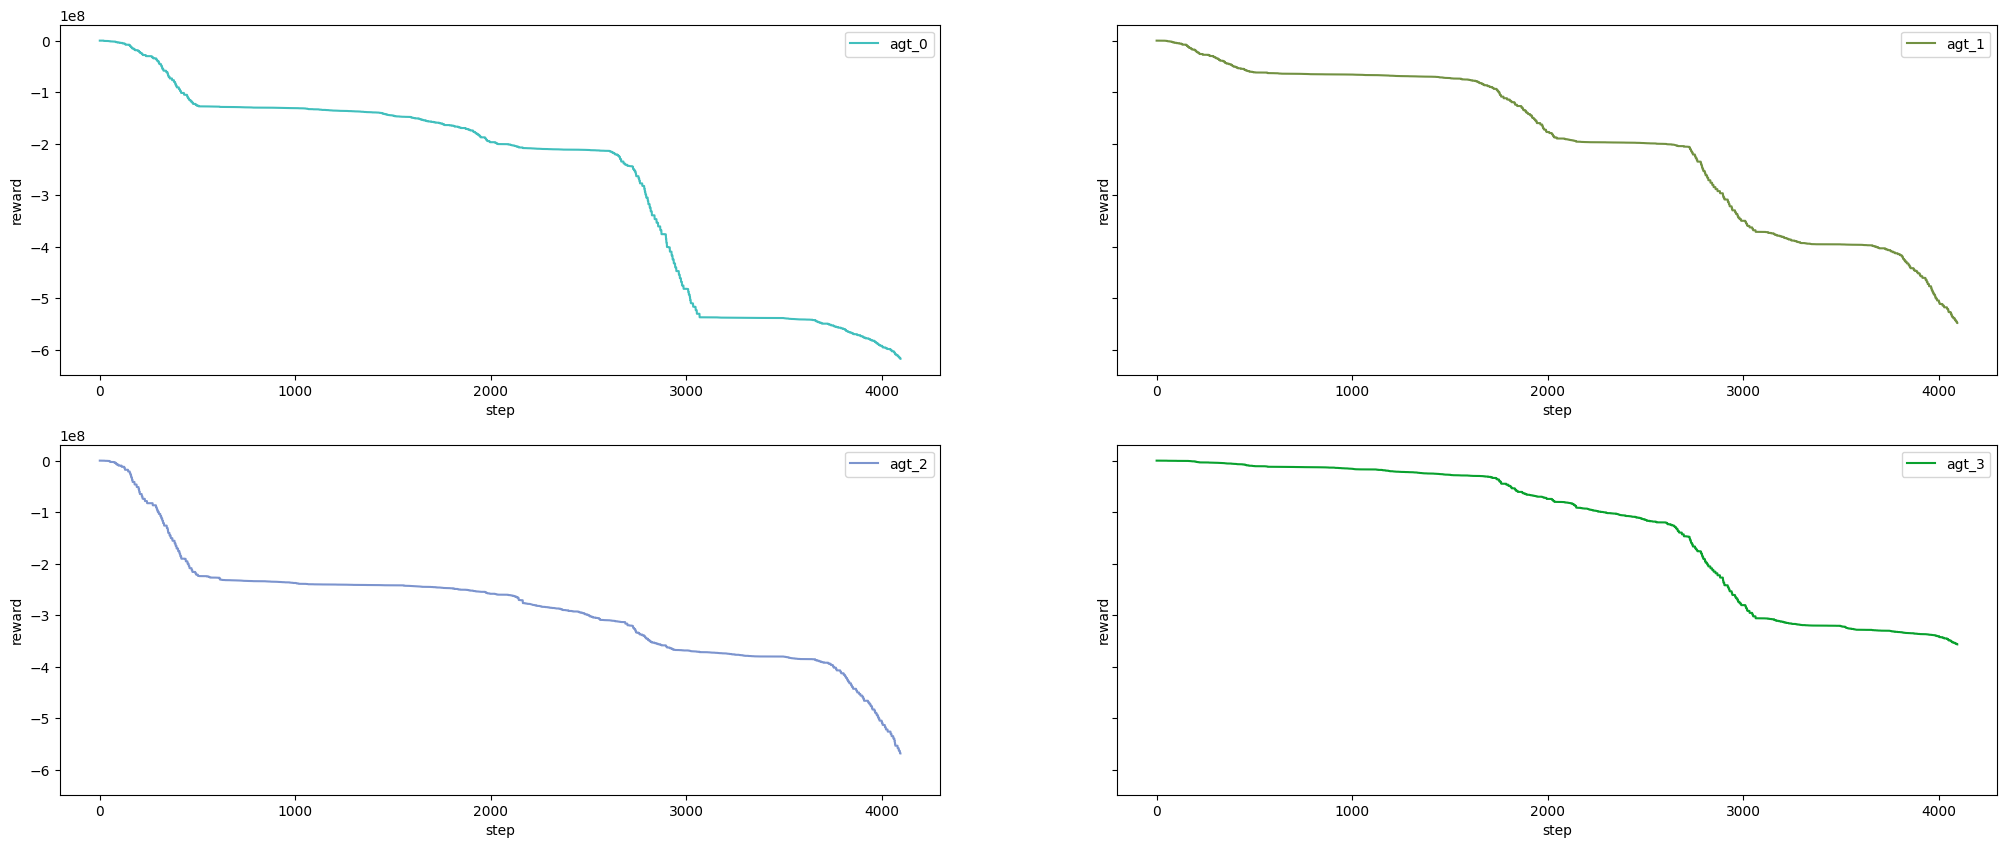

In [16]:
plot_storage(num_agents, init_cash)

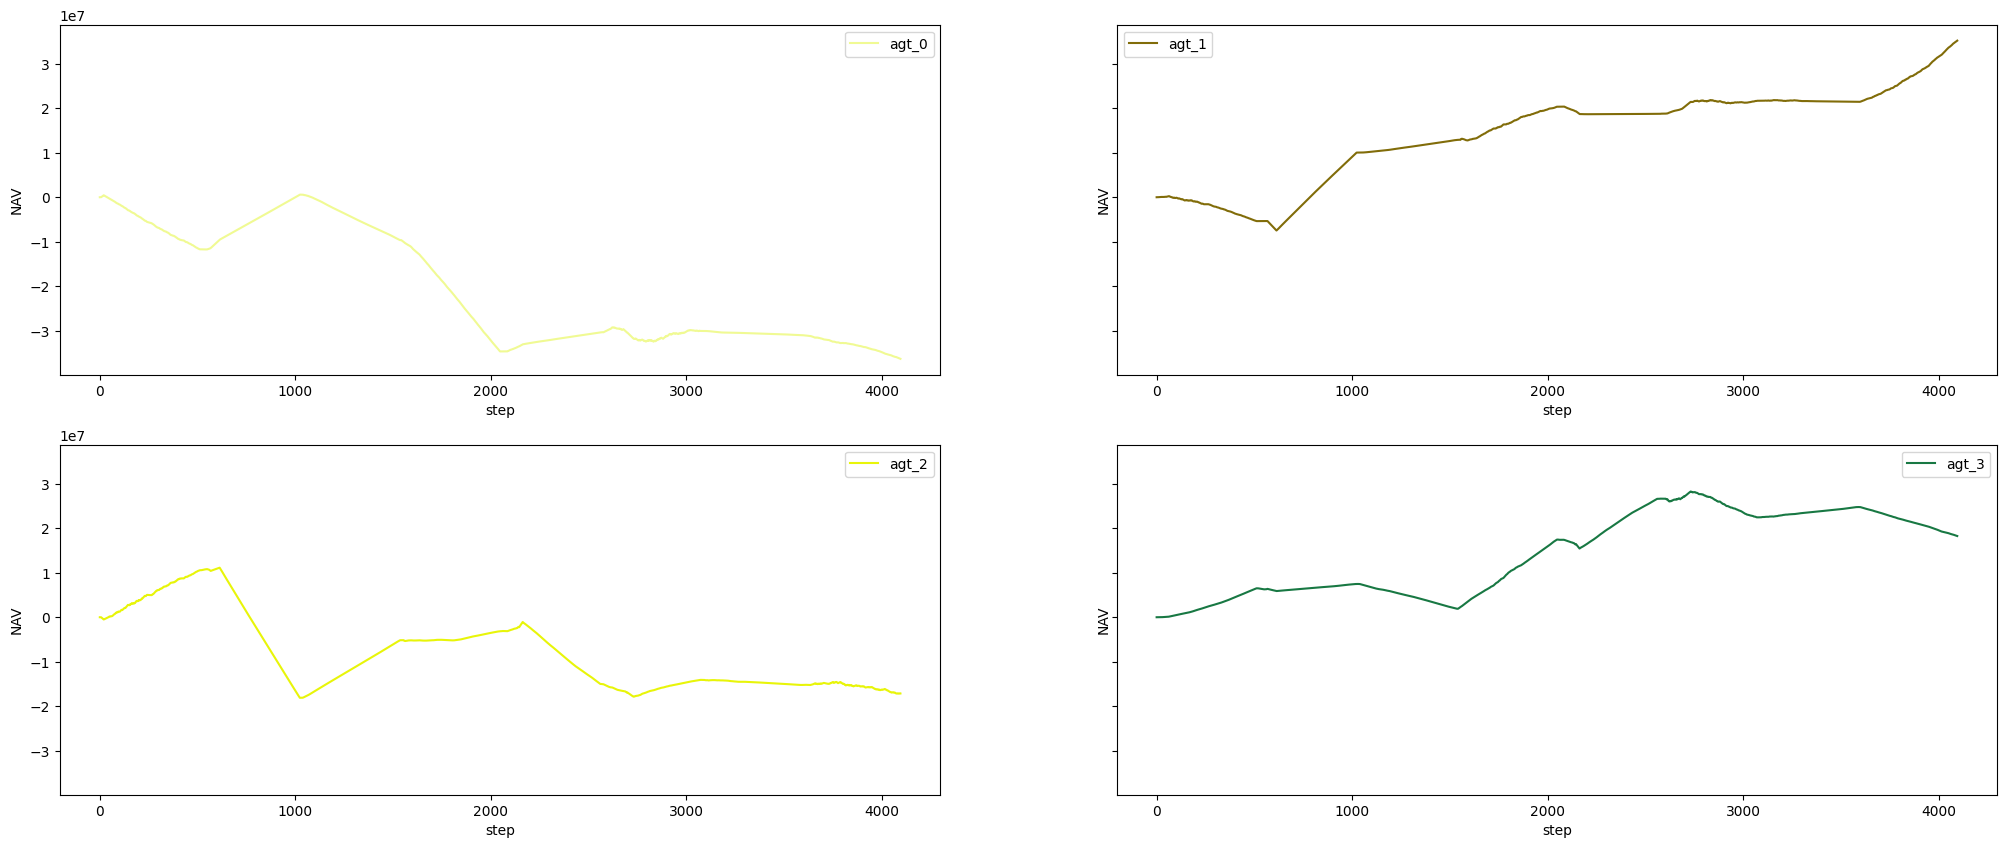

In [17]:
plot_storage(num_agents, init_cash, "step", "NAV")

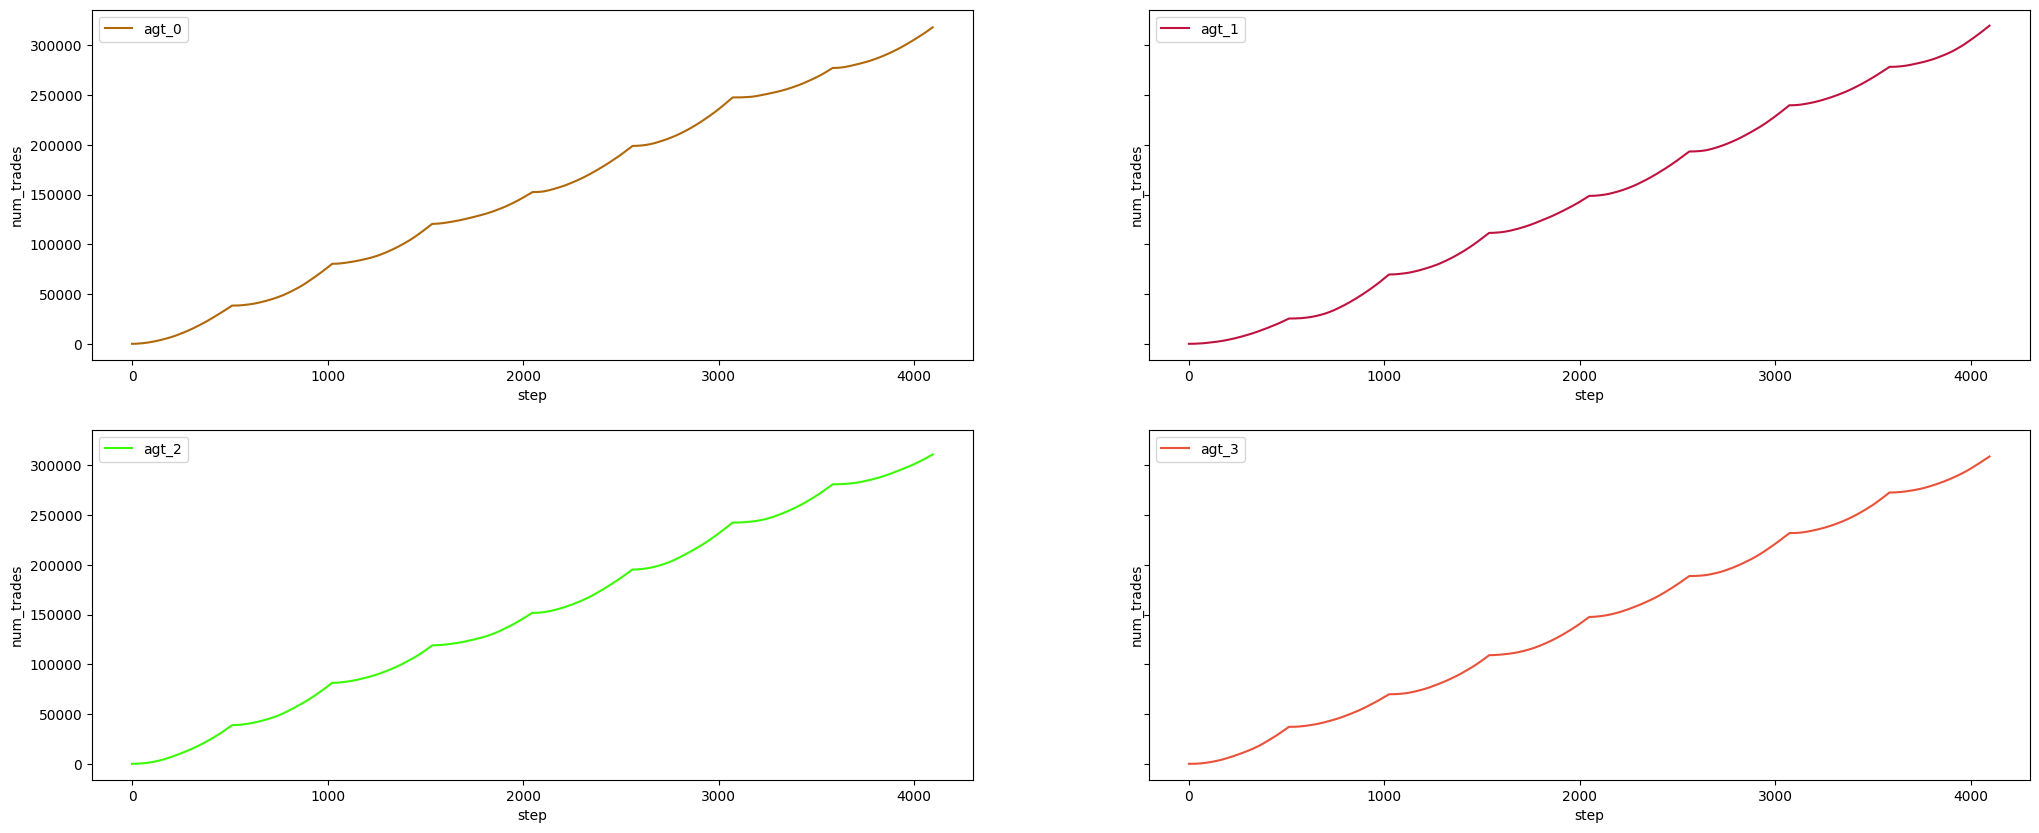

In [18]:
plot_storage(num_agents, init_cash, "step", "num_trades")

# Log/load last episode

In [19]:
log_g_store(log_g_store_dir, num_agents, experiment_id)
load_g_store(log_g_store_dir, num_agents, experiment_id)

3493bded84ca4f128ffe2b3676d76315.gzip
93033865077546ea980f155f36194275.gzip
e2e510fdd82645e4998511df486231d1.gzip


# Plot steps from last episode.

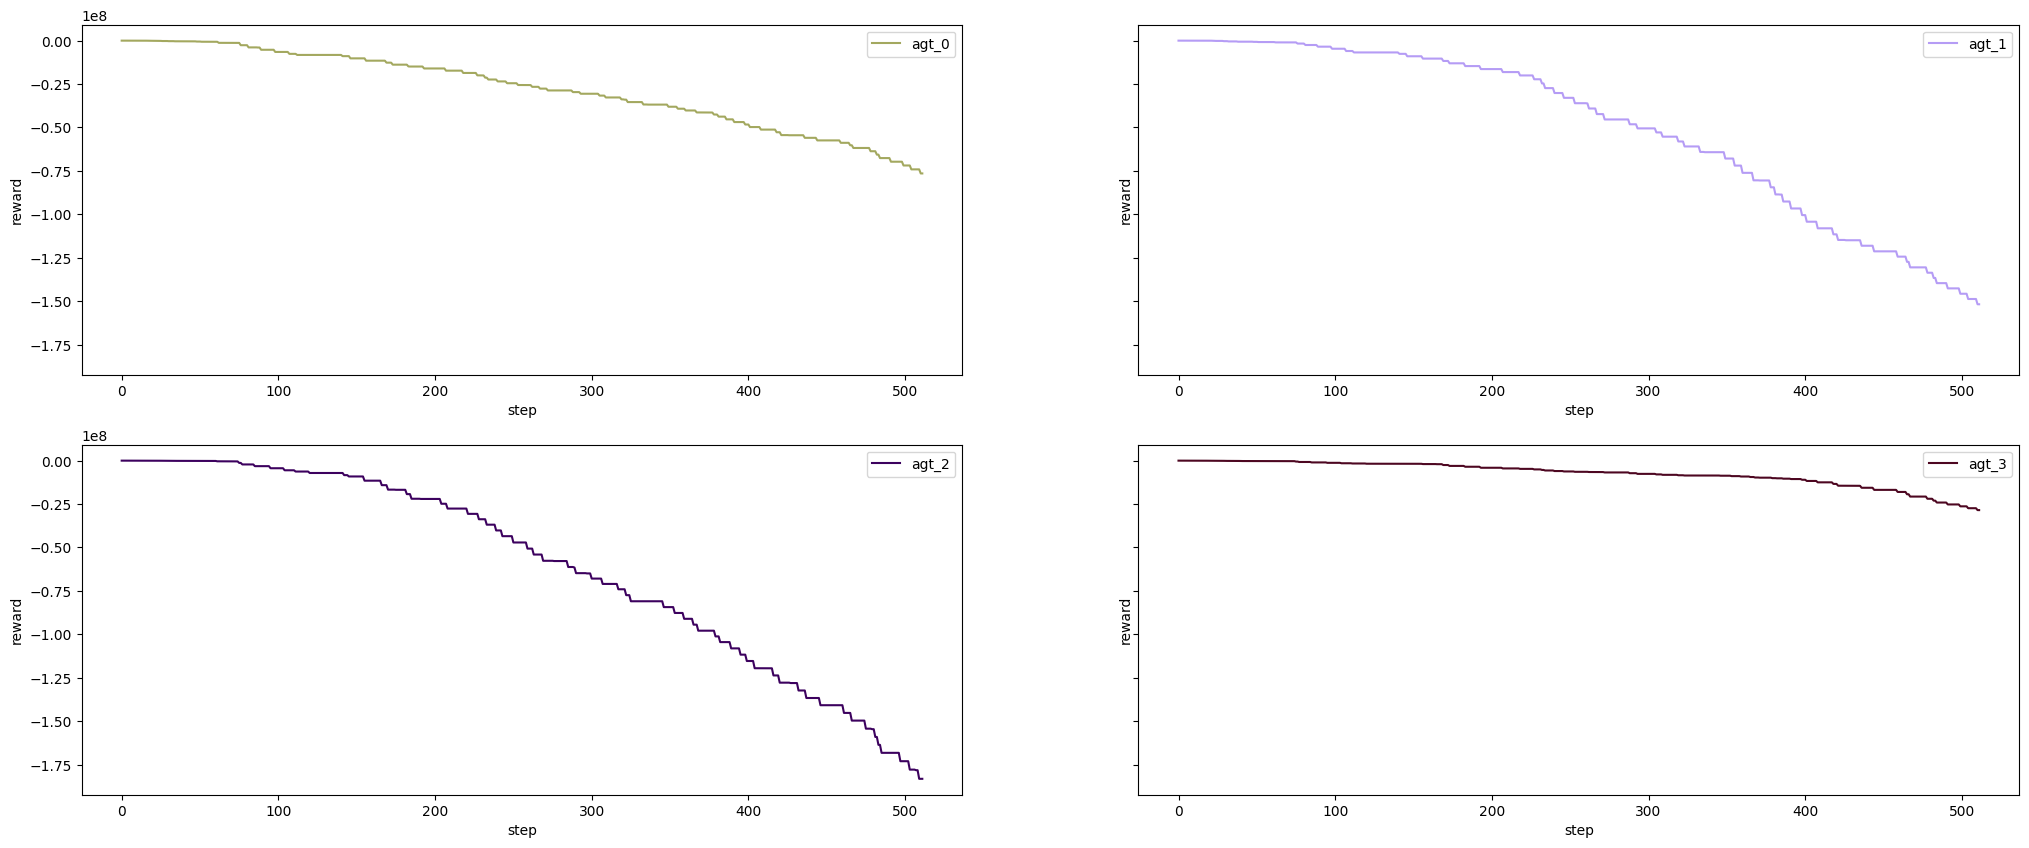

In [20]:
plot_storage(num_agents, init_cash)

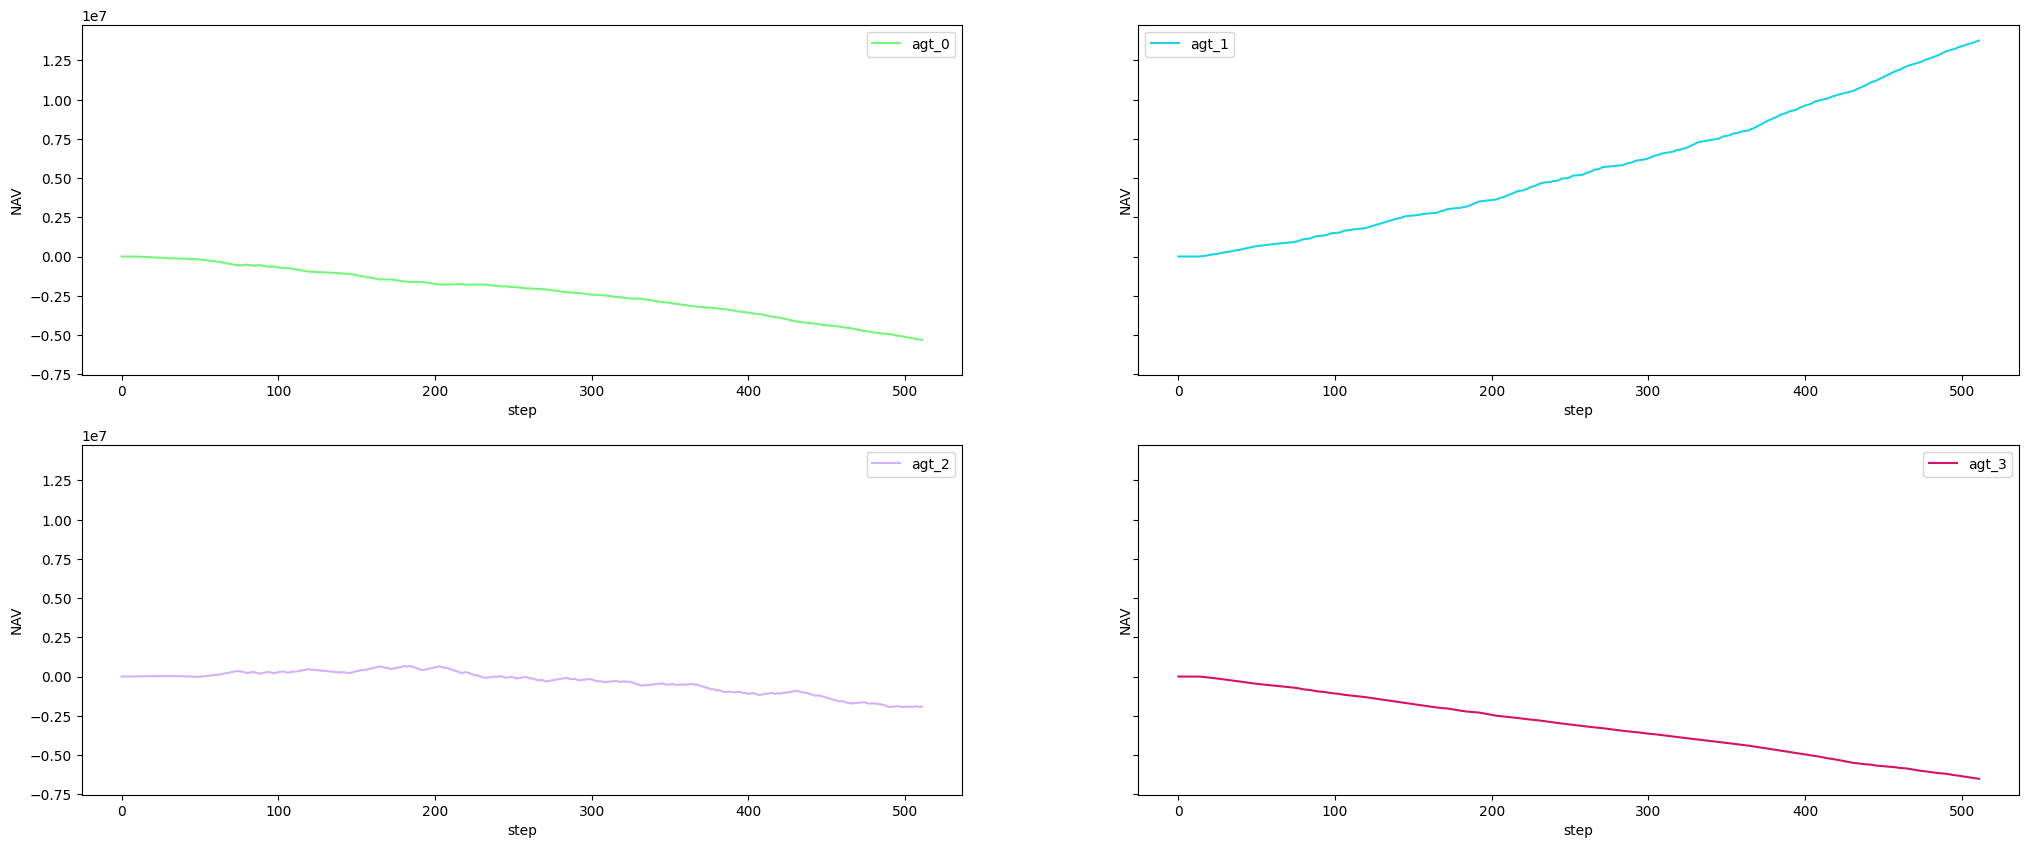

In [21]:
plot_storage(num_agents, init_cash, "step", "NAV")

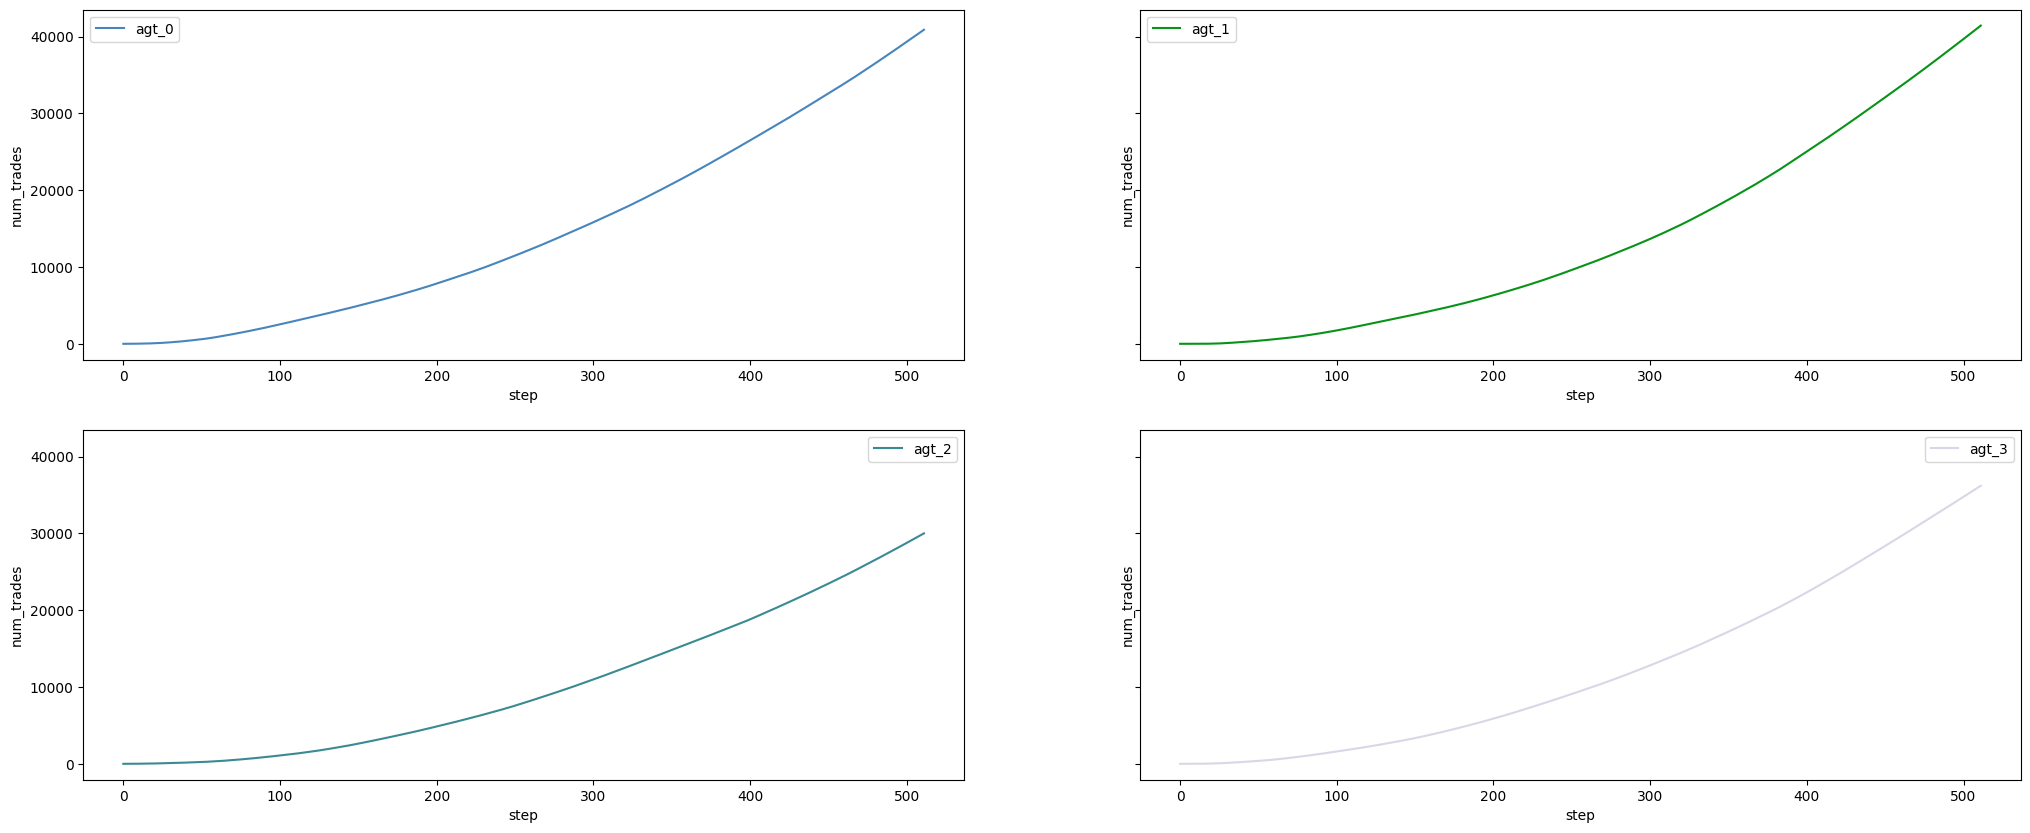

In [22]:
plot_storage(num_agents, init_cash, "step", "num_trades")

# LOB from last episode.

In [23]:
# g_store = ray.util.get_actor("g_store")          
g_store = ray.get_actor("g_store")          

#store = ray.get(g_rere.get_storage.remote())

depth = 10
bid_size, bid_price, ask_size, ask_price = ray.get(g_store.get_obs_from_agt.remote(0, depth))

# LOB order imbalance

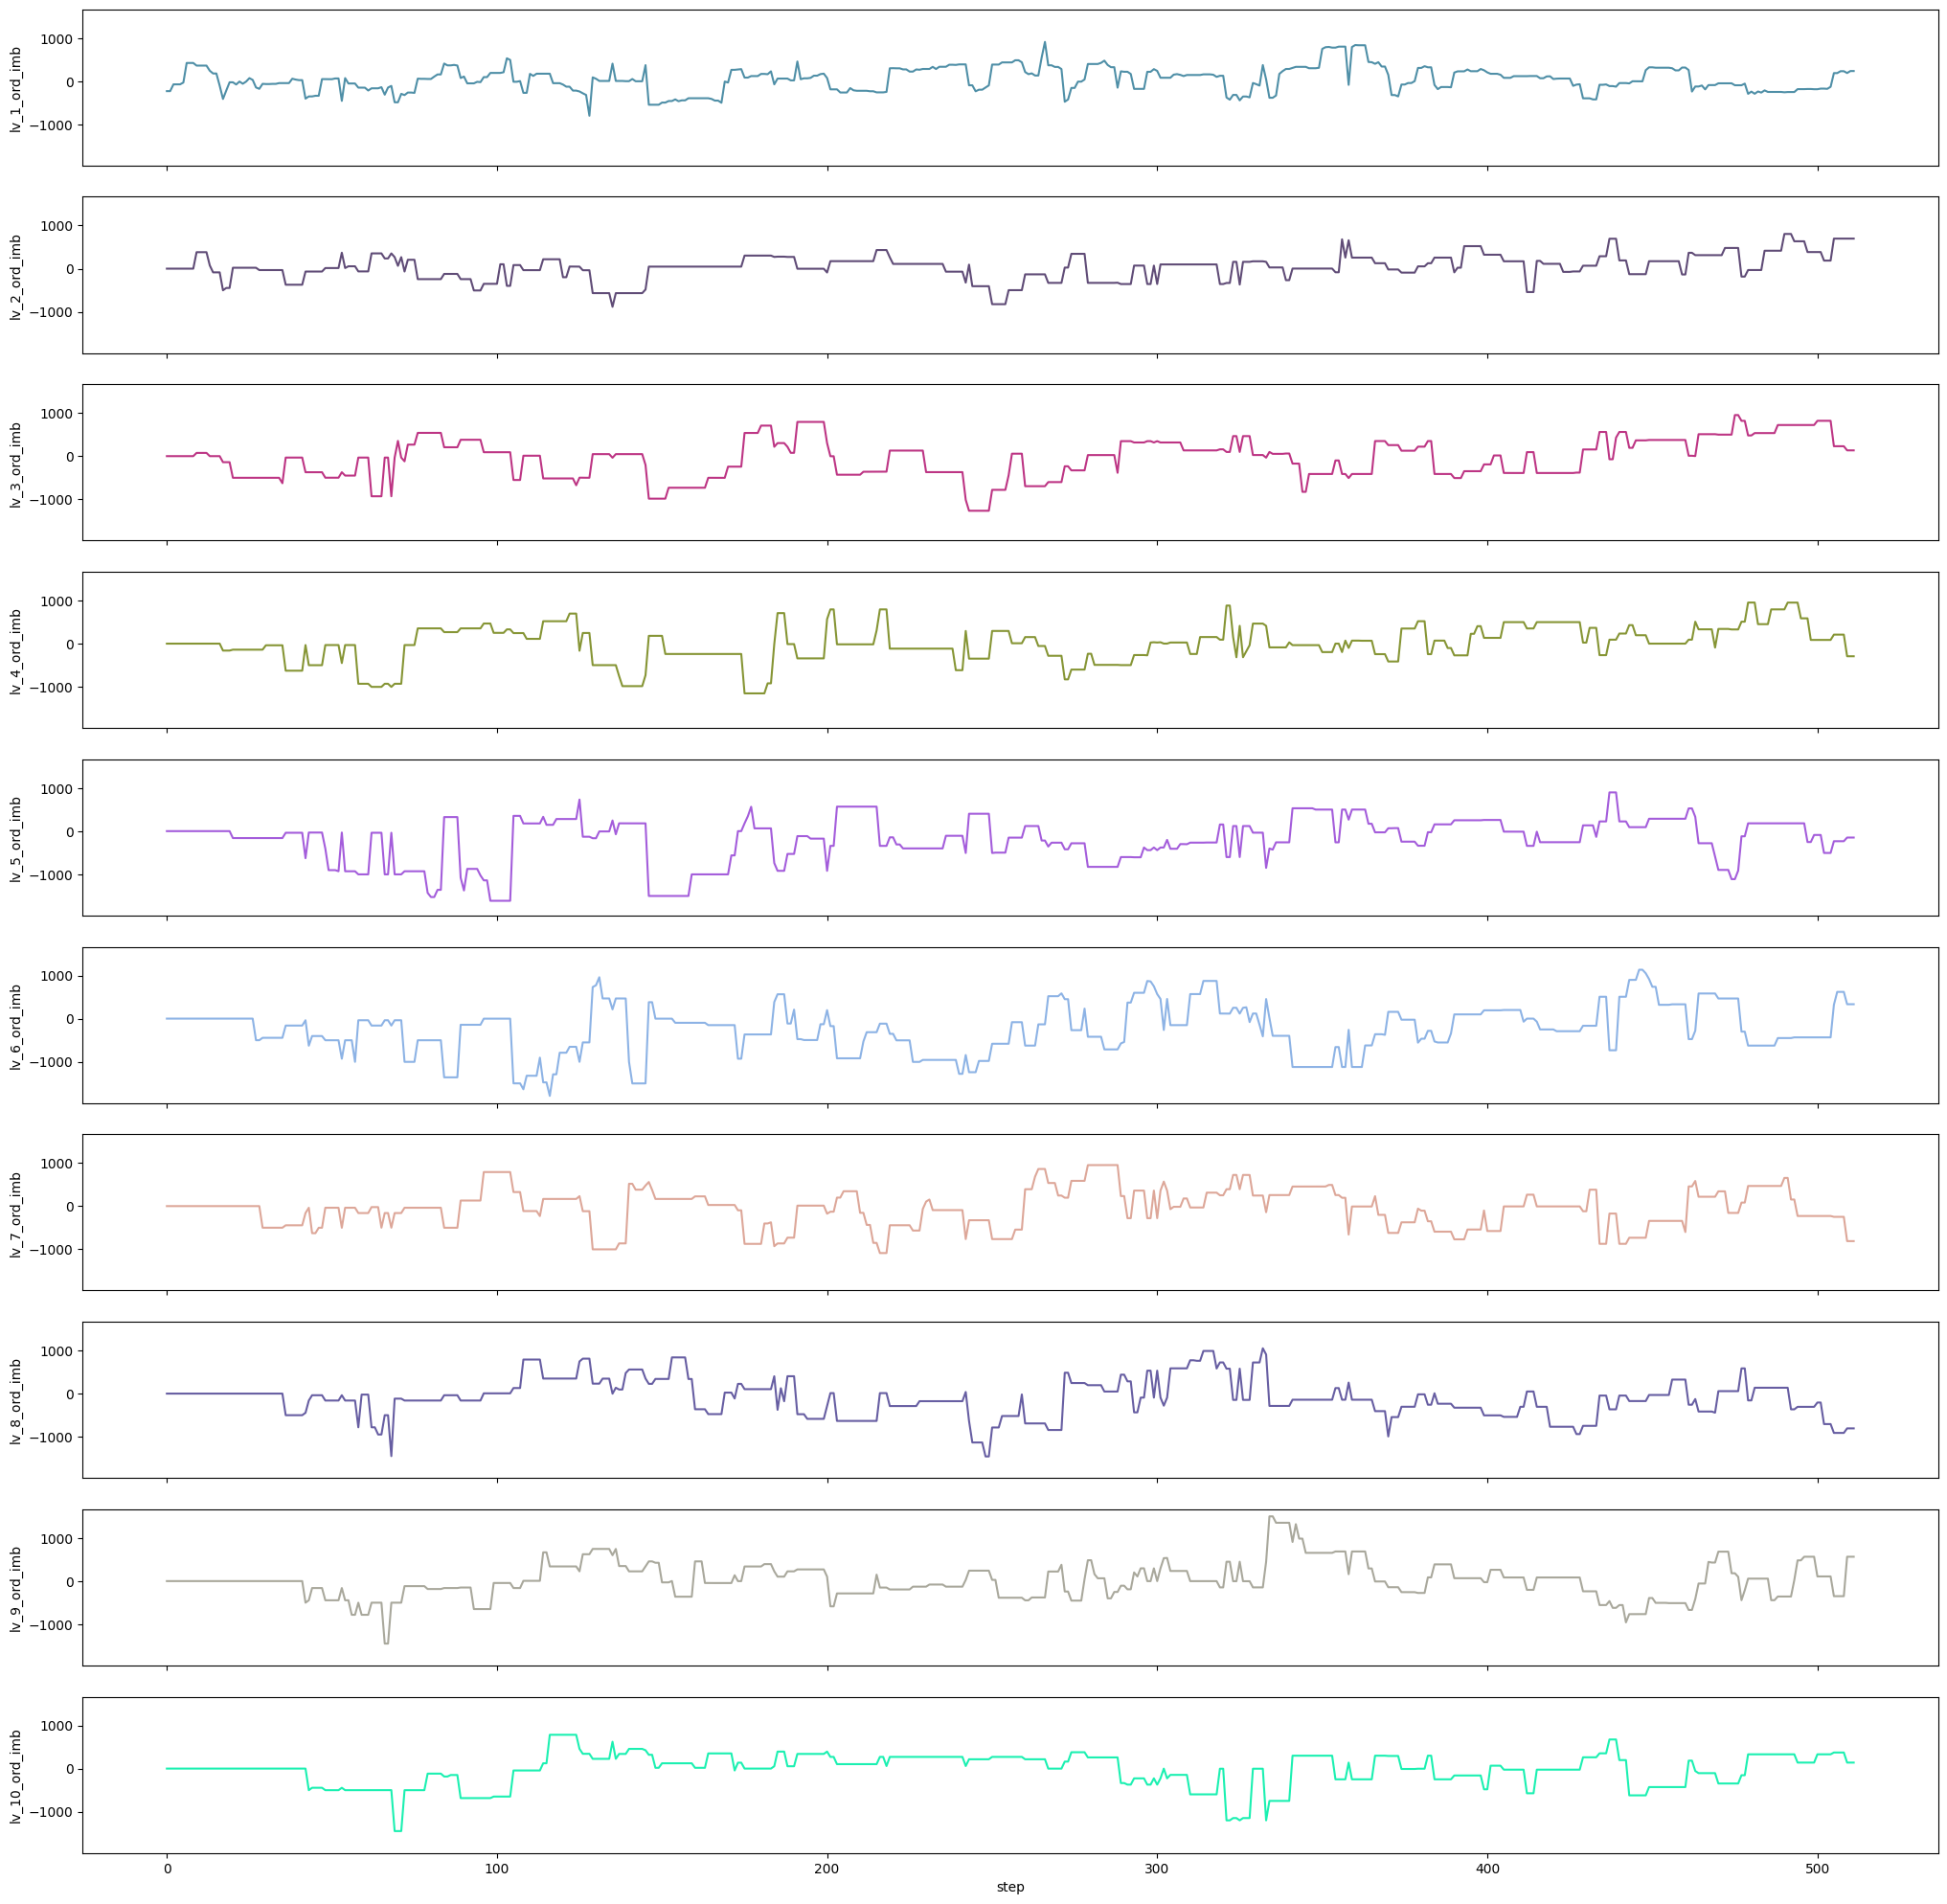

In [24]:
ord_imb_store = ord_imb(bid_size, ask_size)
plot_LOB_subplot(ord_imb_store, depth, '_ord_imb') 

# LOB sum of order imbalance

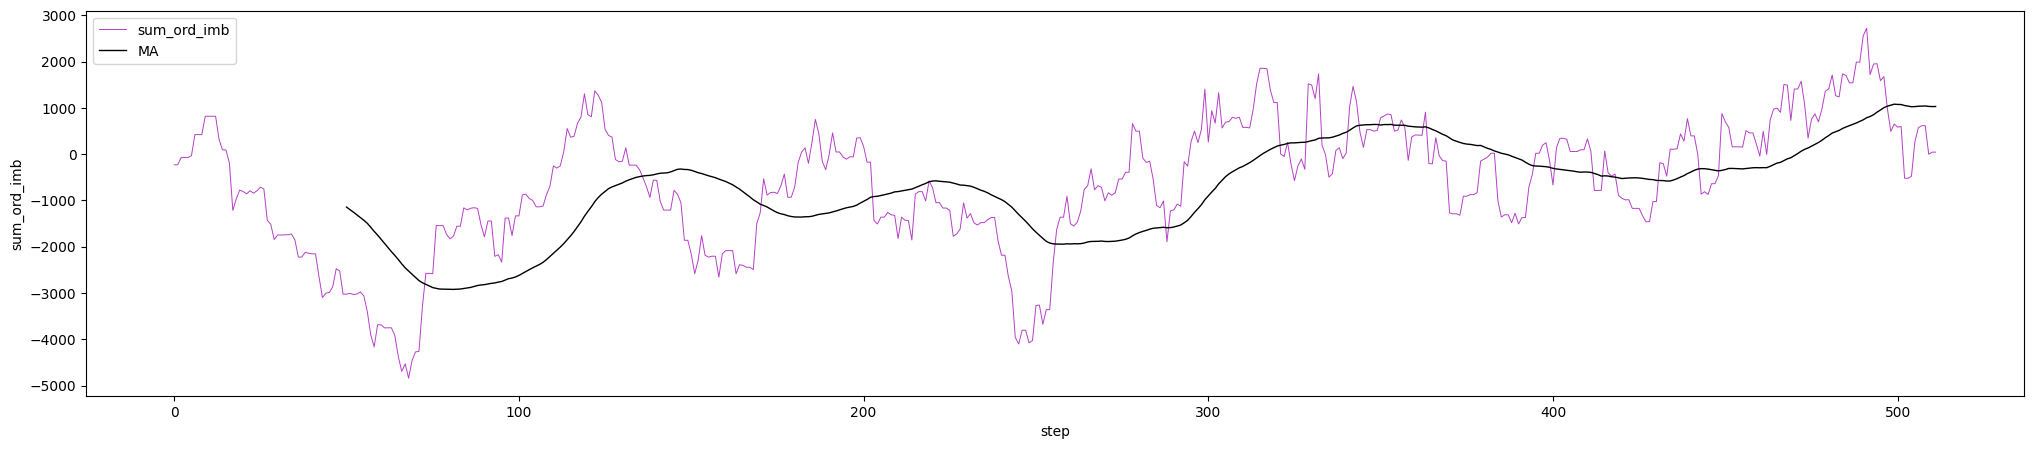

In [25]:
ord_imb_store = np.asarray(ord_imb_store)
sum_ord_imb_store = sum_ord_imb(ord_imb_store)
plot_sum_ord_imb(sum_ord_imb_store, "sum_ord_imb")

# LOB mid price (subplot)

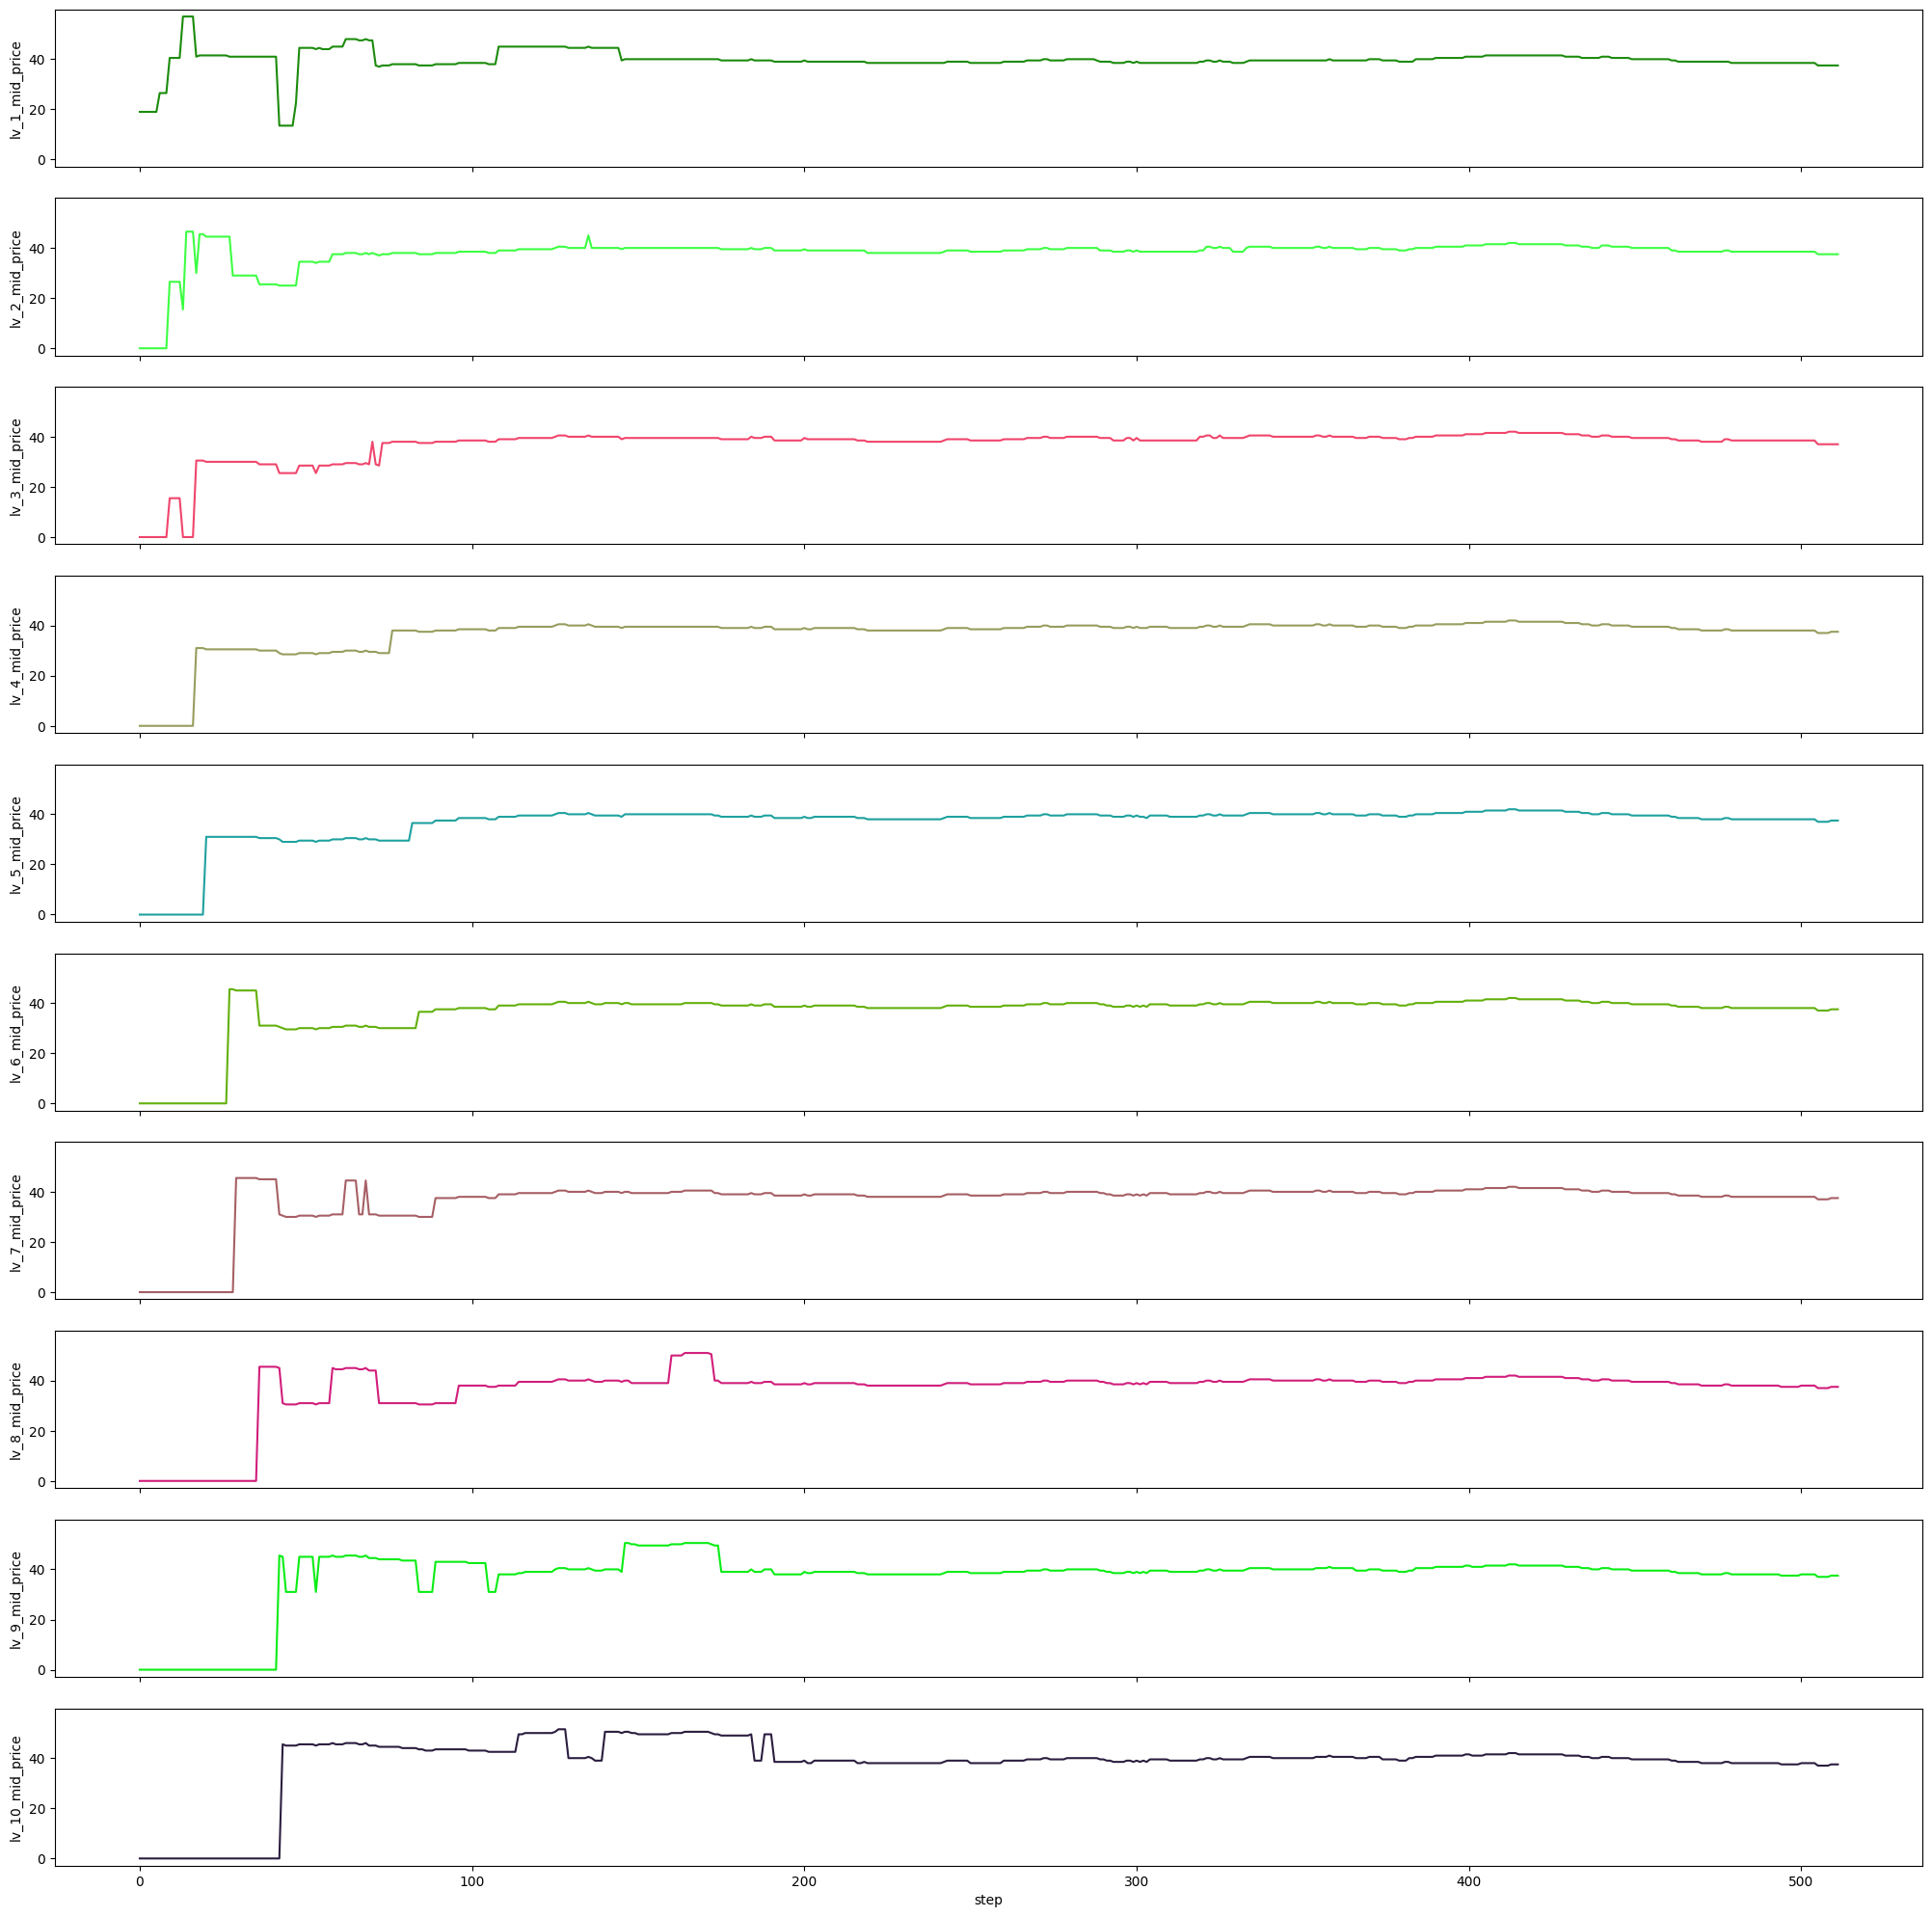

In [26]:
mid_price_store = mid_price(bid_price, ask_price)
plot_LOB_subplot(mid_price_store, depth, '_mid_price')    

# LOB mid prices 

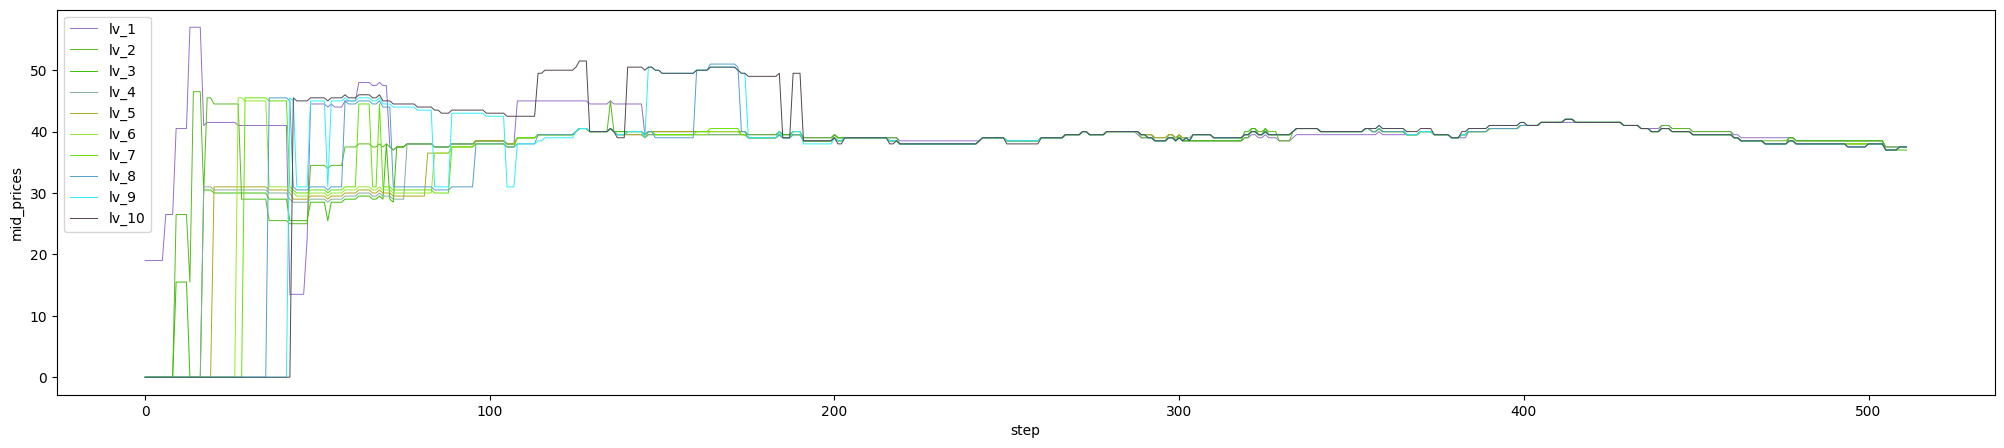

In [27]:
plot_mid_prices(mid_price_store,)

# LOB bid size

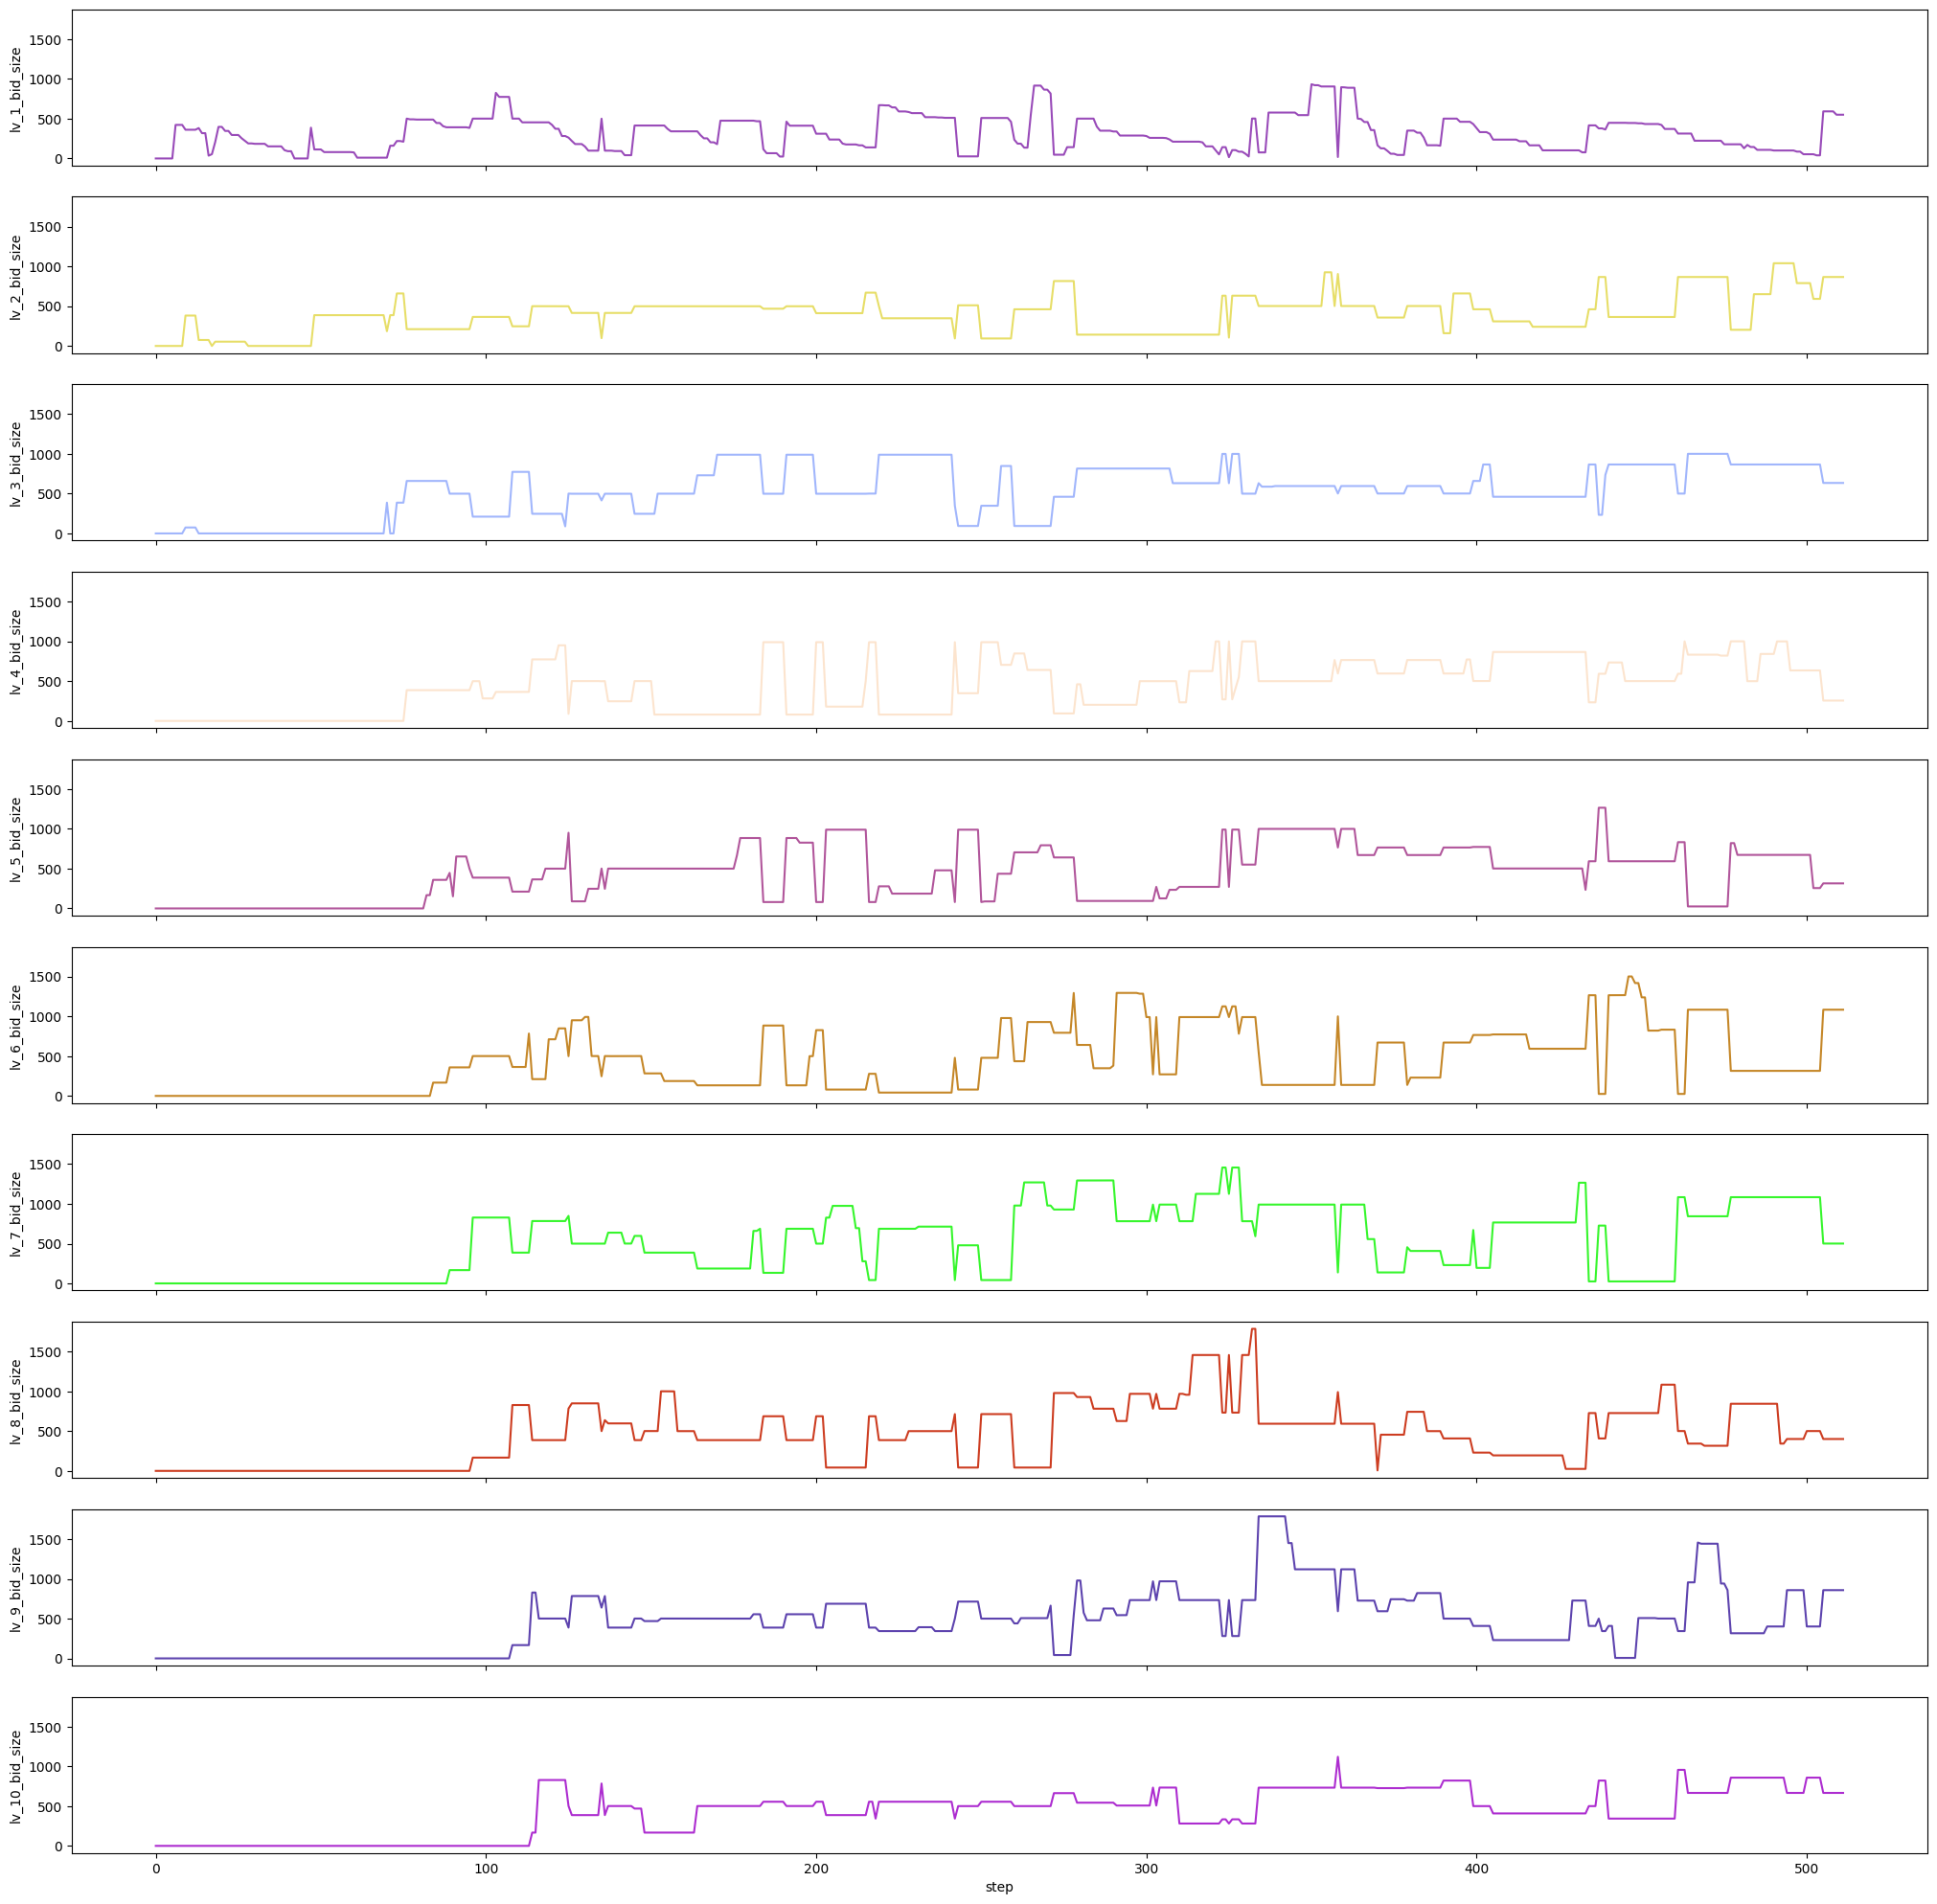

In [28]:
plot_LOB_subplot(bid_size, depth, '_bid_size')    

#LOB ask size

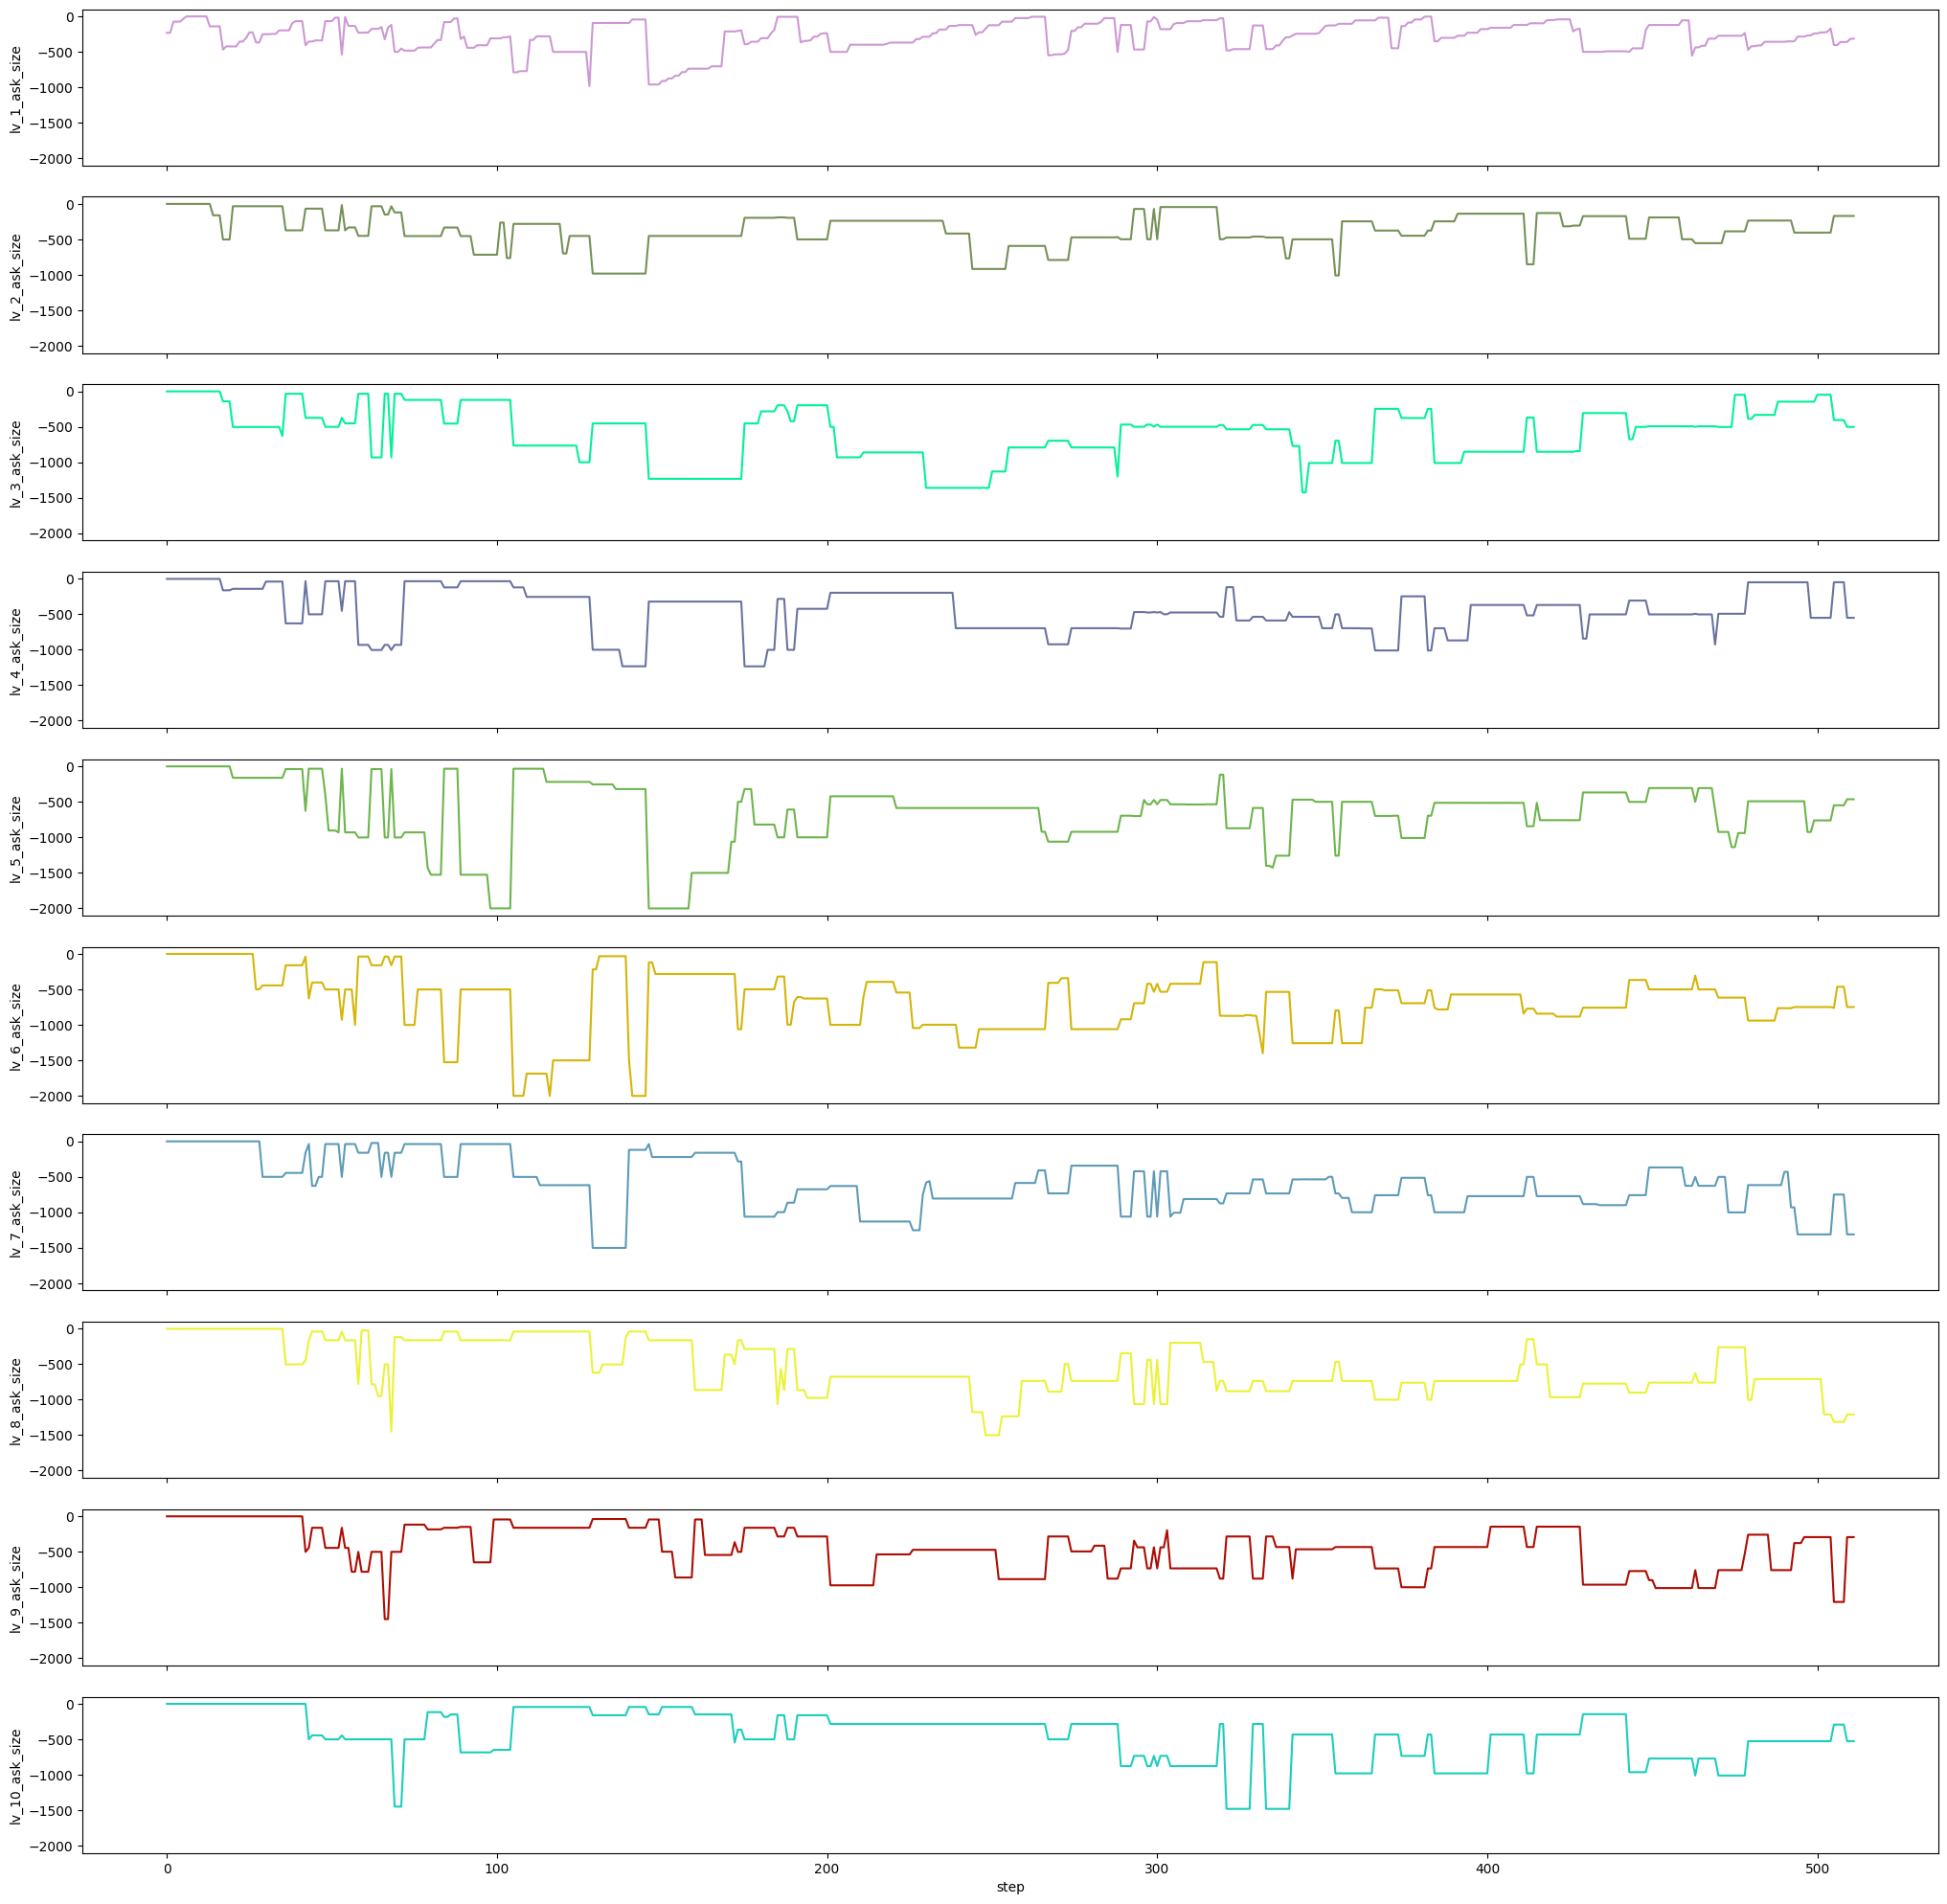

In [29]:
plot_LOB_subplot(ask_size, depth, '_ask_size')    

# LOB bid price

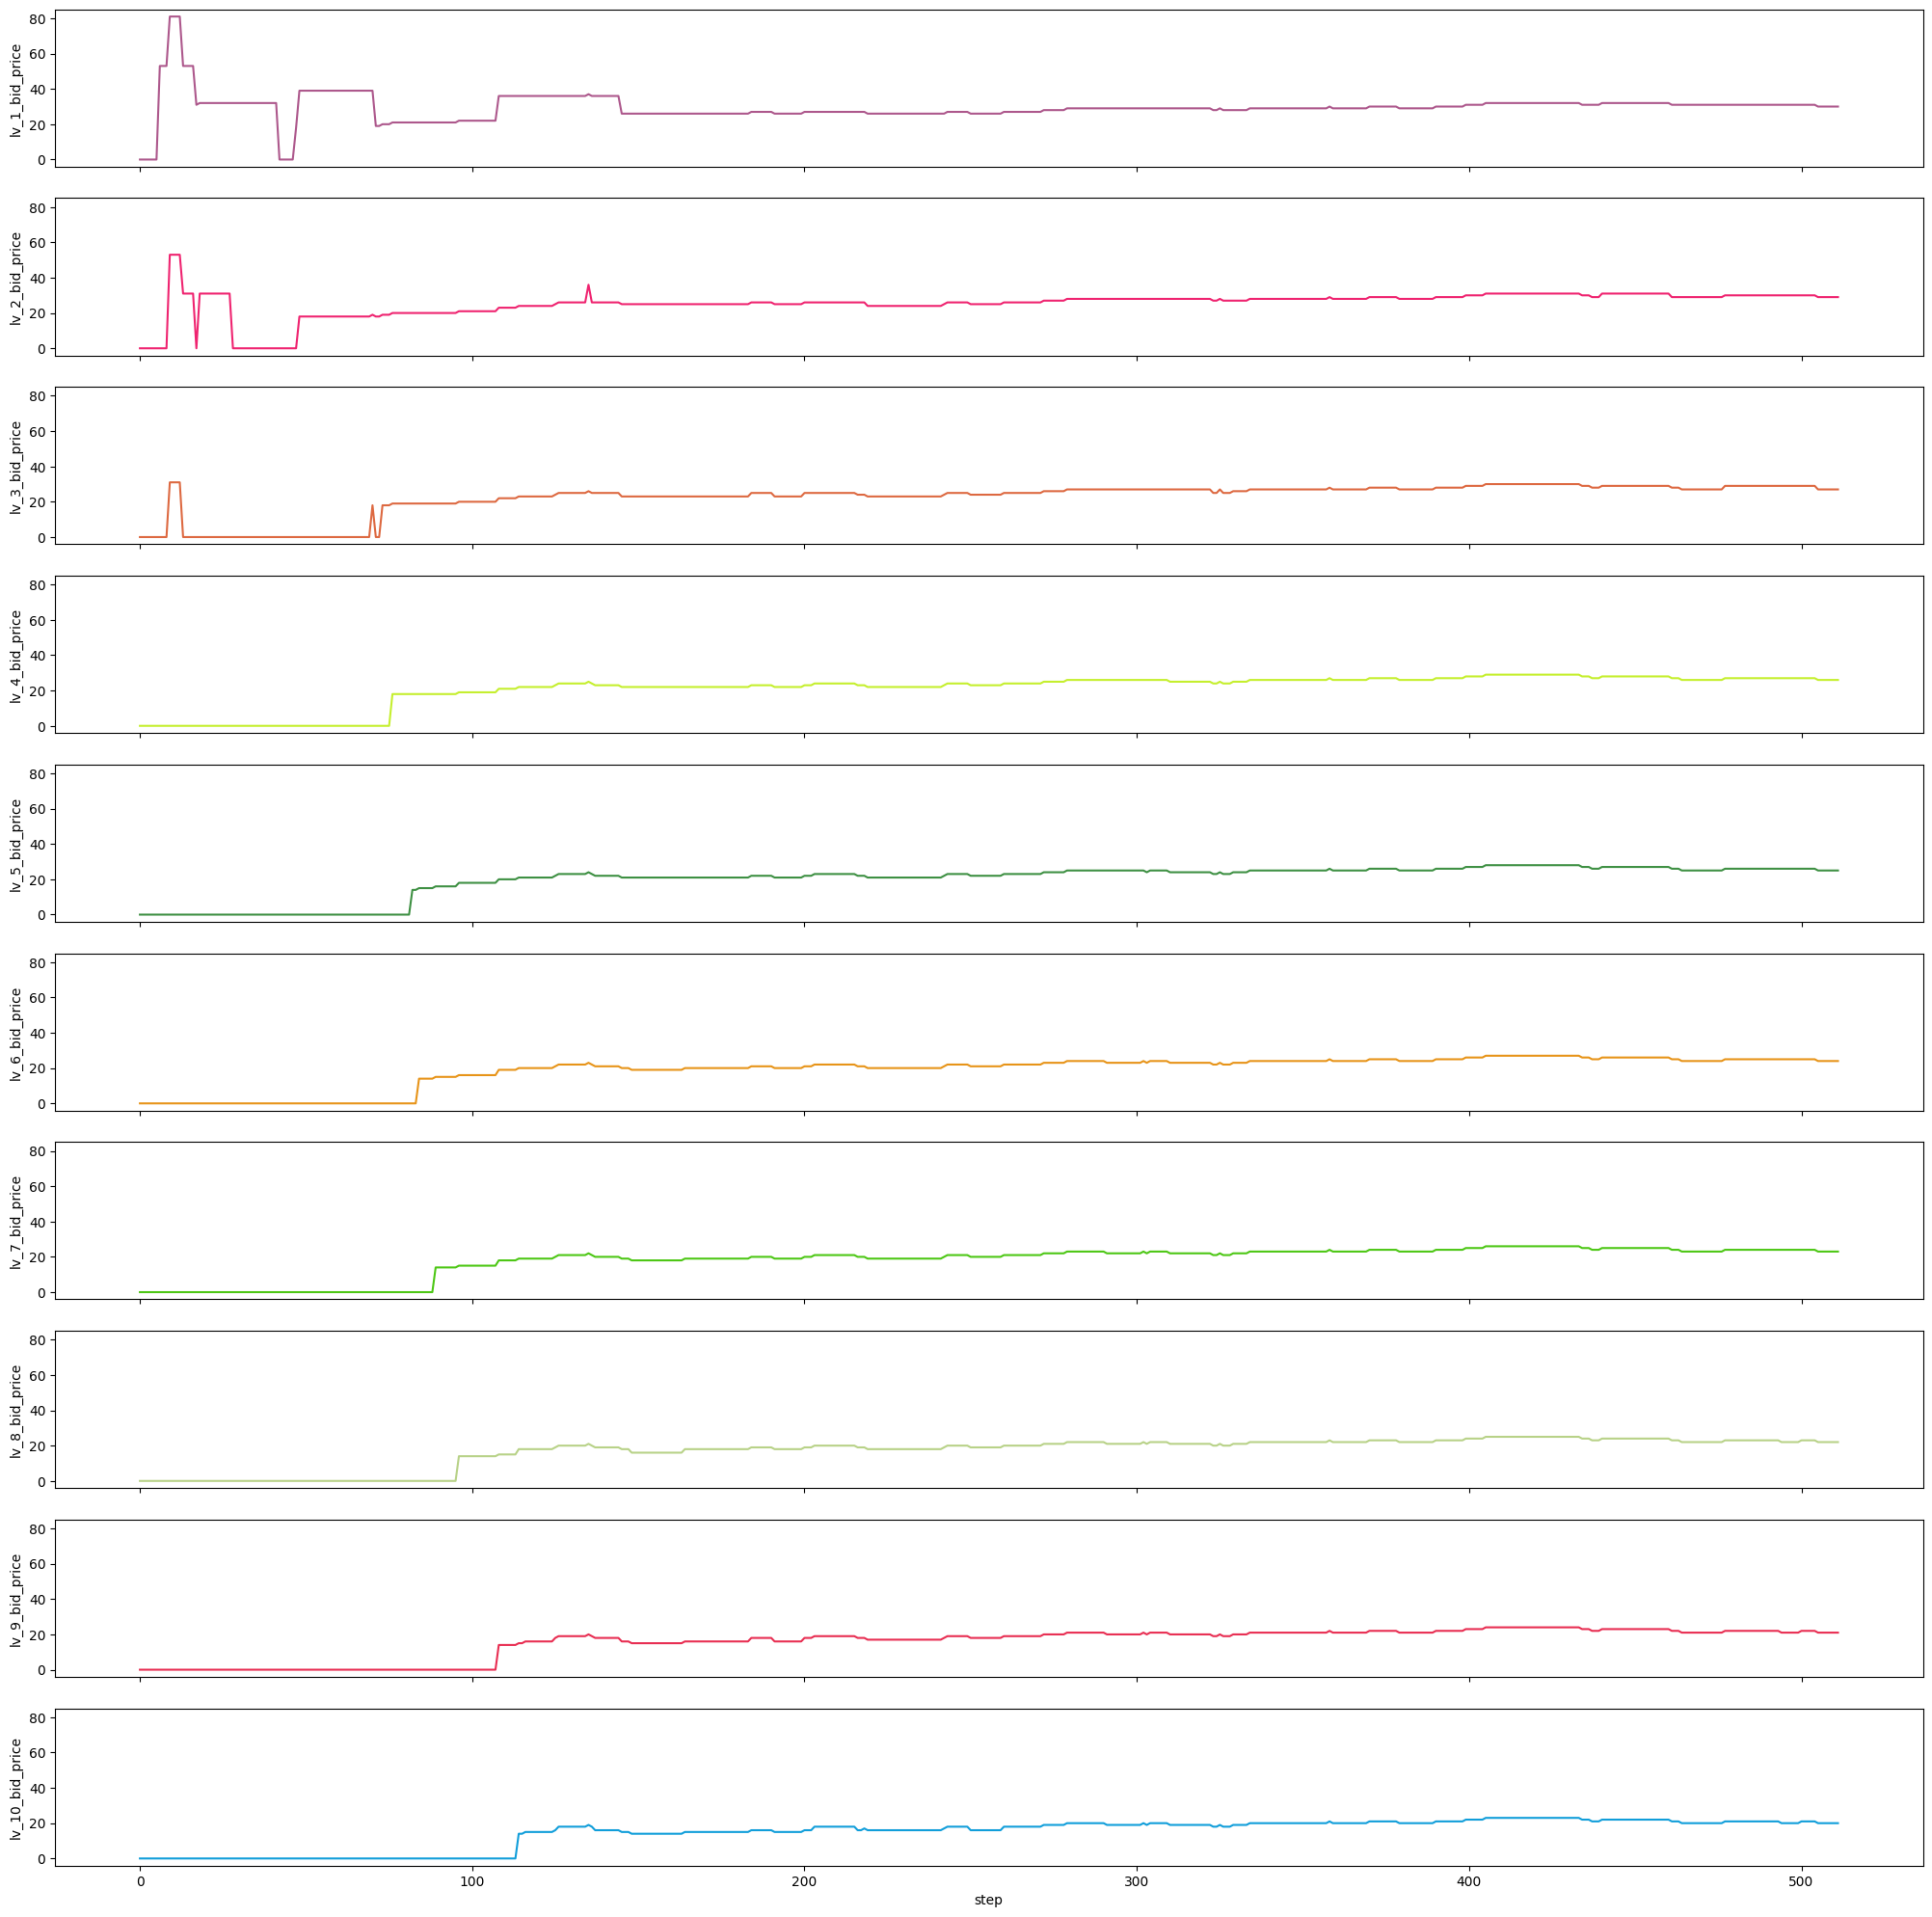

In [30]:
plot_LOB_subplot(bid_price, depth, '_bid_price')    

# LOB ask price

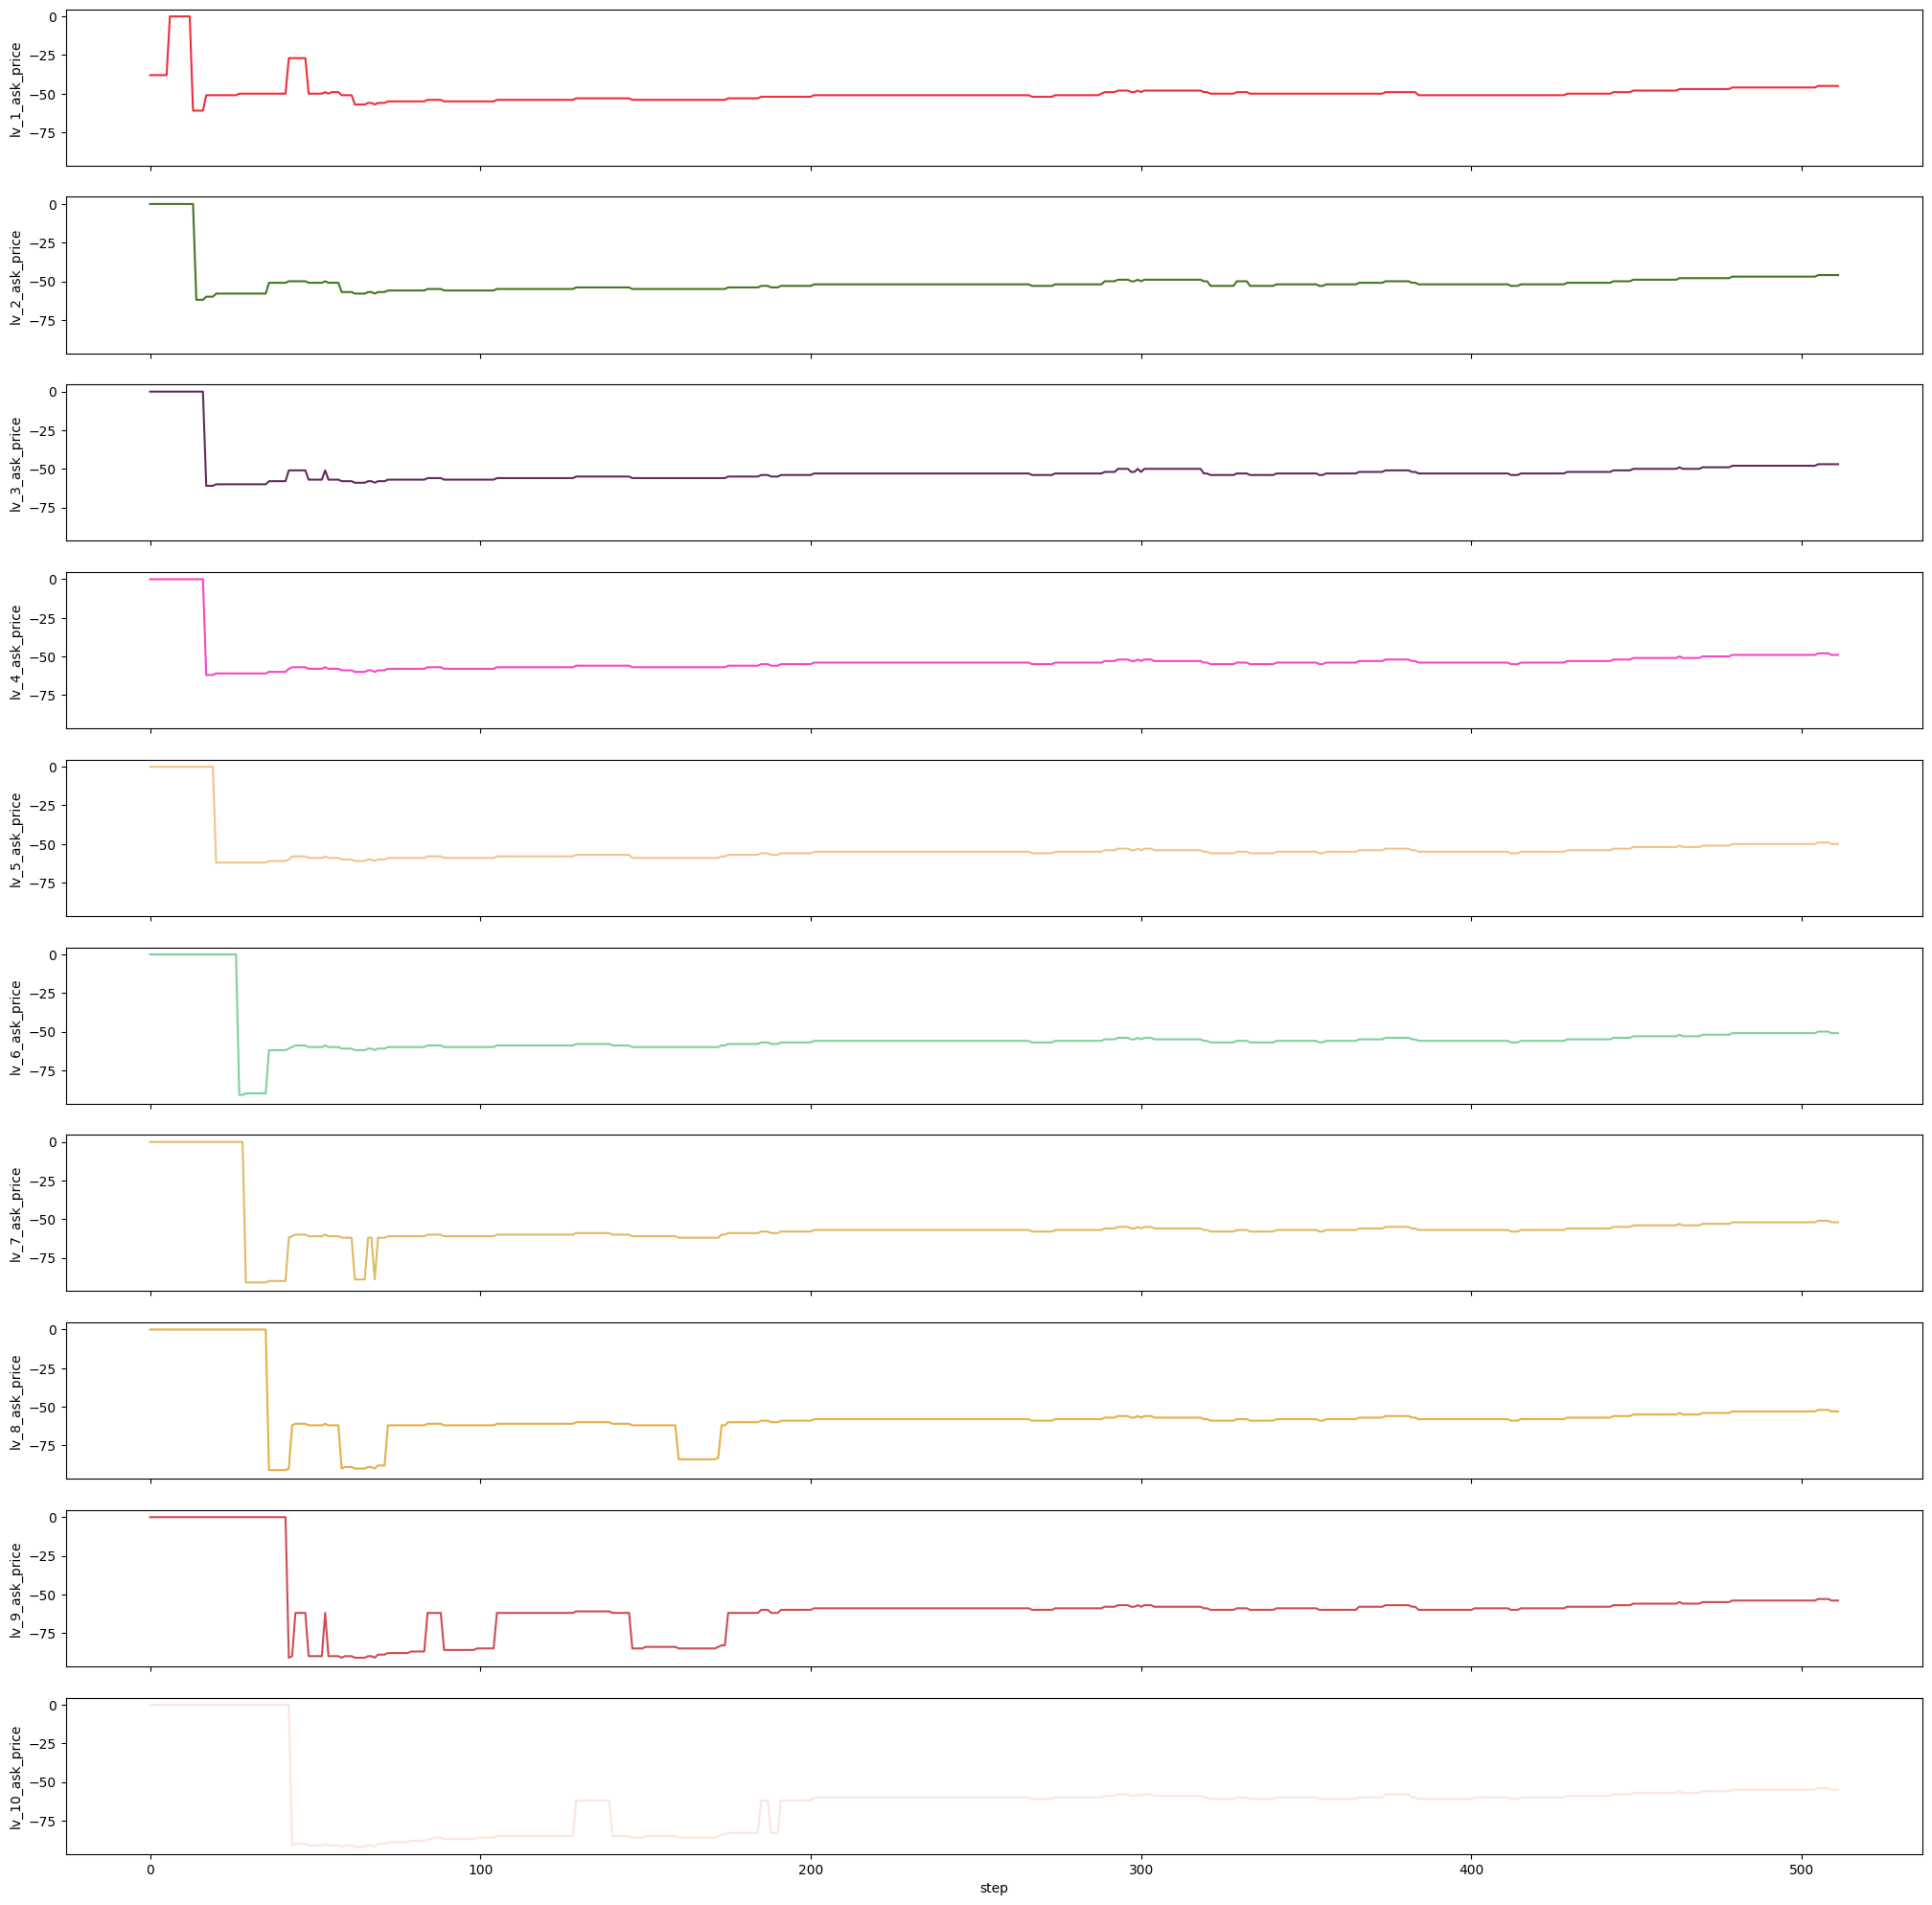

In [31]:
plot_LOB_subplot(ask_price, depth, '_ask_price')    